In [1]:
# To display images
from IPython.display import Image
import PIL.Image

# To display json data
import pandas as pd

# Evaluating Different Signature Detection Methods

I have tested the following:
1. Method 1 - Signature Extractor - Adapted from https://github.com/ahmetozlu/signature_extractor
2. Method 2 - Signature Detect - https://pypi.org/project/signature-detect/
3. Method 3 - Hybrid of Method 1 and 2
4. Method 4 - https://github.com/saifkhichi96/signature-extraction
5. Method 5 - Hybrid of Method 1 and 4
6. Method 6 - Hybrid of Method 1,2 and 4

## Dataset Used

I have used a subset of the Tobacco800 dataset which contains 776 images of scanned documents with signatures on them. All images have accompanying xml files which contain various information including the bounding box information for the signatures. It stores the x and y coordinates for the top left edge of the bounding box and the width and height of the box.  
Since I am more comfortable with JSON, I converted this information into the following json format for each image:
```
{
    "filename.tif": [
        xmin,
        ymin,
        xmax,
        ymax
    ],
}
```
(xmin, ymin) --> top left edge of bbox, (xmax, ymax) --> bottom right edge of bbox.

In [2]:
# Show ground truth bbox values
ground_truth_values_json = pd.read_json('evaluation/ground_truth_bbox.json')
ground_truth_values_json

,suh90a00.tif,amk00a00.tif,mwj41f00.tif,umw13f00.tif,fny38c00-page05_5.tif,fzx20e00-page02_2.tif,vdr55d00.tif,dgw64a00.tif,ciy01a00-page02_2.tif,wau30a00-page9_3.tif,...,lfj35f00.tif,fjx9aa00.tif,lec44c00.tif,wav95e00-page03_3.tif,hfv39d00.tif,jxp35f00.tif,eqp14e00-page02_2.tif,qit05f00-page2_36.tif,qit05f00-page2_22.tif,yrz52d00.tif
0,651,1234,651,1355,158,1254,511,1018,636,679,...,762,146,794,302,1635,727,1436,592,673,894
1,1123,2436,784,1952,1260,1614,1437,1586,756,1613,...,890,1641,1836,1888,2855,1345,1413,729,1175,1594
2,851,2140,964,2153,514,1692,1006,1358,849,1346,...,962,1200,1486,833,2306,849,2060,934,966,1295
3,1195,2809,860,2126,1360,1746,1552,1645,811,1794,...,988,1854,2011,2024,2965,1423,1576,875,1284,1718


## Calculating bboxes using the Various Methods

Bounding boxes are calculated for all images in the dataset for all the different methods. The bbox coordinates are saved in a JSON file in the following format:
```
{
    "filename.tif": [
        xmin,
        ymin,
        xmax,
        ymax
    ],
}
```

## Evaluating accuracy using Intersection over Union ratio


This is the ratio of area of intersection of the ground truth bbox and the calculated bbox to the area of union of ground truth bbox and calculated bbox. If the two bboxes do not overlap at all then this ratio is 0 and if they overlap completely and are of equal dimensions then this ratio is 1.

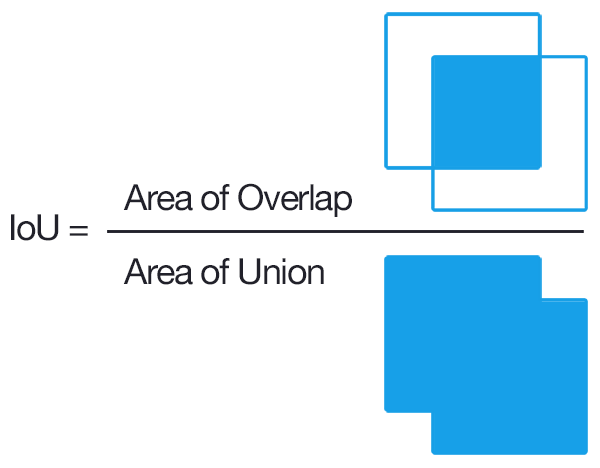

In [3]:
# Show iou visualization
Image('evaluation/iou.png')

In [4]:
# The following code example is used to calculate the iou ratio
# For this we must have the ground truth bbox top left and bottom right edge coordinates and
# the calculated bbox top left and bottom right edge coordinates

# ground truth bbox coordinates example values
xmin_gt = 774
ymin_gt = 1684
xmax_gt = 1160
ymax_gt = 1801

# calculated bbox coordinates example values
xmin_c = 766
ymin_c = 1662
xmax_c = 1168
ymax_c = 1809

# ground truth and calculated bbox areas for union area
gt_bbox_area = (xmax_gt - xmin_gt) * (ymax_gt - ymin_gt)
calc_bbox_area = (xmax_c - xmin_c) * (ymax_c - ymin_c)

union_area = gt_bbox_area * calc_bbox_area

# coordinates of intersection
xmin_inter = max(xmin_gt, xmin_c)
ymin_inter = max(ymin_gt, ymin_c)
xmax_inter = min(xmax_gt, xmax_c)
ymax_inter = min(ymax_gt, ymax_c)

# if the bboxes do not overlap then the ratio must be 0
if xmax_inter < xmin_inter or ymax_inter < ymin_inter:
    iou = 0.0
# if they do overlap then we use this formula
else:
    intersection_area = (xmax_inter - xmin_inter) * (ymax_inter - ymin_inter)
    iou = intersection_area / float(gt_bbox_area + calc_bbox_area - intersection_area)
    #get it in %age
    iou = round(iou * 100, 2)
    
print(f'IOU --> {iou}%')

IOU --> 76.42%


### Evaluating accuracy using Intersection over Union ratio

Intersection over union ratio is calculated for all images. The results are stored in a JSON file with the format:
```
{
    "filename.tif": {
        "ground_truth": [
            xmin,
            ymin,
            xmax,
            ymax
        ],
        "calculated": [
            xmin,
            ymin,
            xmax,
            ymax
        ],
        "intersection": [
            xmin,
            ymin,
            xmax,
            ymax
        ],
        "iou_in_percentage": 0.0
    },    
}
```

- (xmin, ymin) -> coordinates for top left edge of bbox for ground truth, calculated and intersection boxes  
- (xmax, ymax) -> coordinates for bottom right edge of bbox for ground truth, calculated and intersection boxes  
- iou_in_percentage -> Float value with the iou ratio * 100

## Test Image
The following image has been used as a test image for all methods.

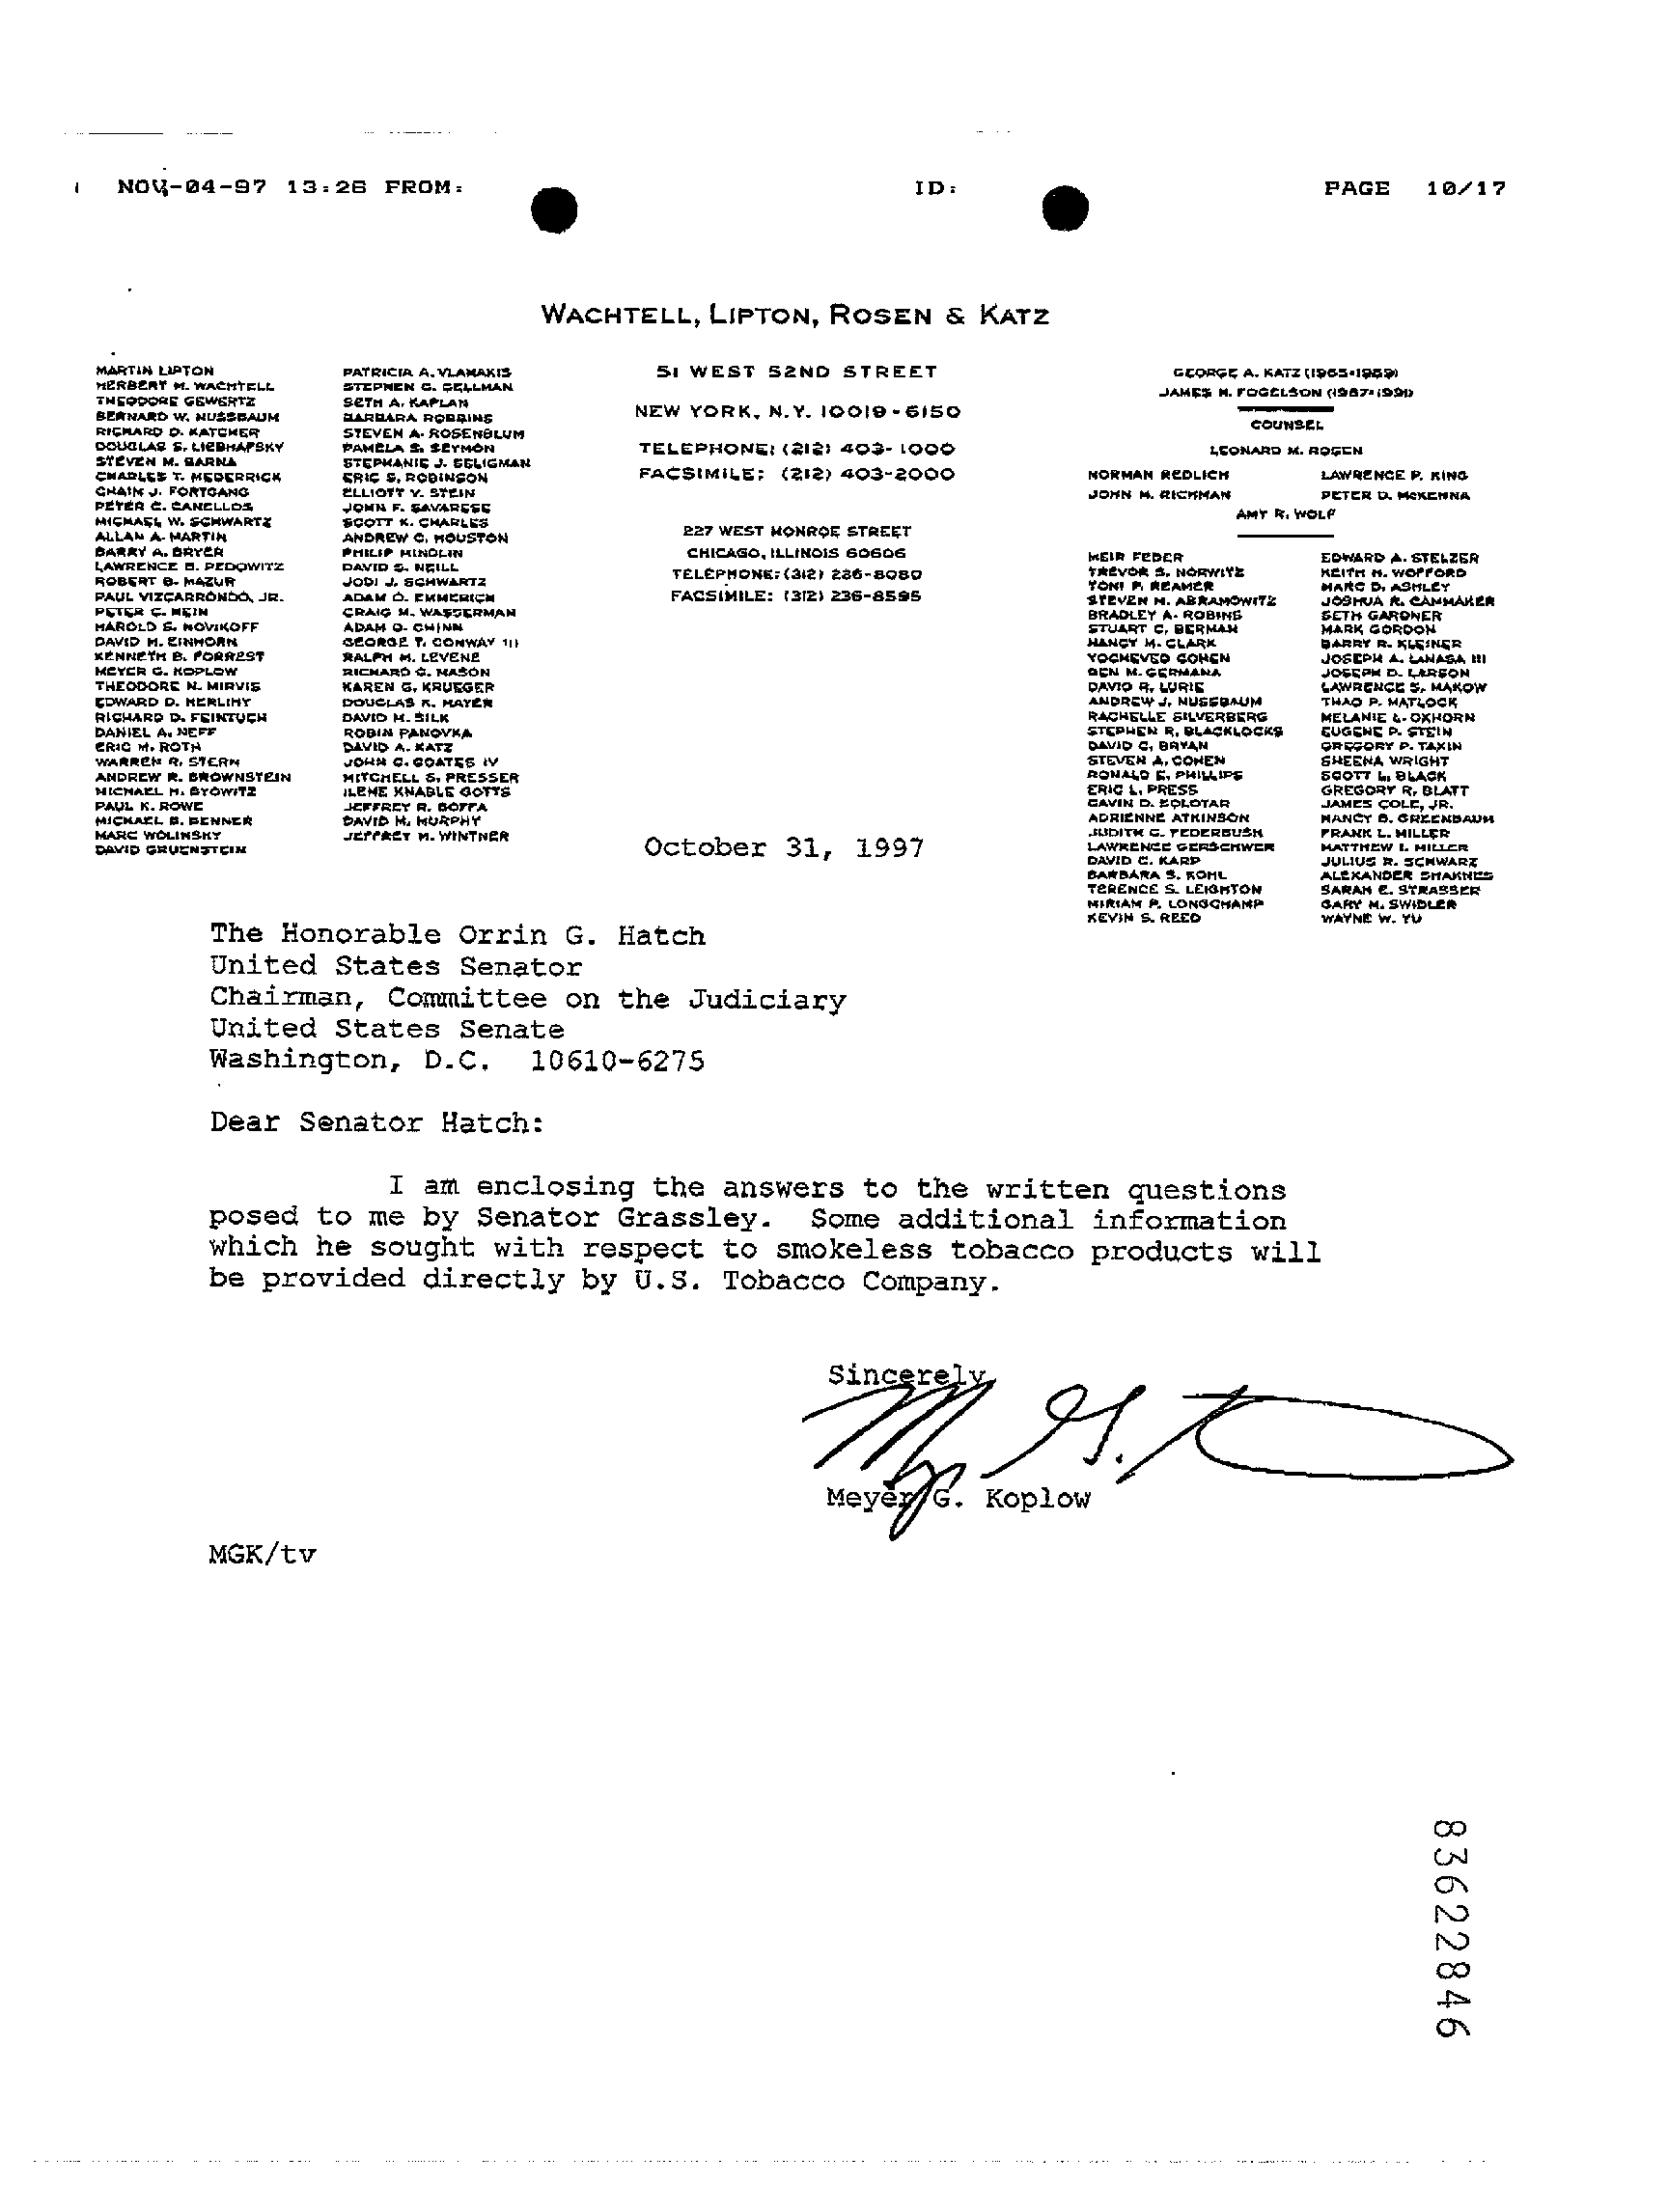

In [5]:
test_image = 'evaluation/test_image.png'
Image(test_image)

## 1. Method 1

### Getting bbox

In [7]:
# The following code is used to find bbox around signature
import cv2
from method_1.module.signature_removal import Signature_removal

test_image = 'evaluation/test_image.png'

test_image = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)

xmin, ymin, xmax, ymax = Signature_removal(test_image).get_signature_bbox()

print(f'xmin -> {xmin}\n'
      f'ymin -> {ymin}\n'
      f'xmax -> {xmax}\n'
      f'ymax -> {ymax}')

xmin -> 816
ymin -> 1398
xmax -> 1585
ymax -> 1613


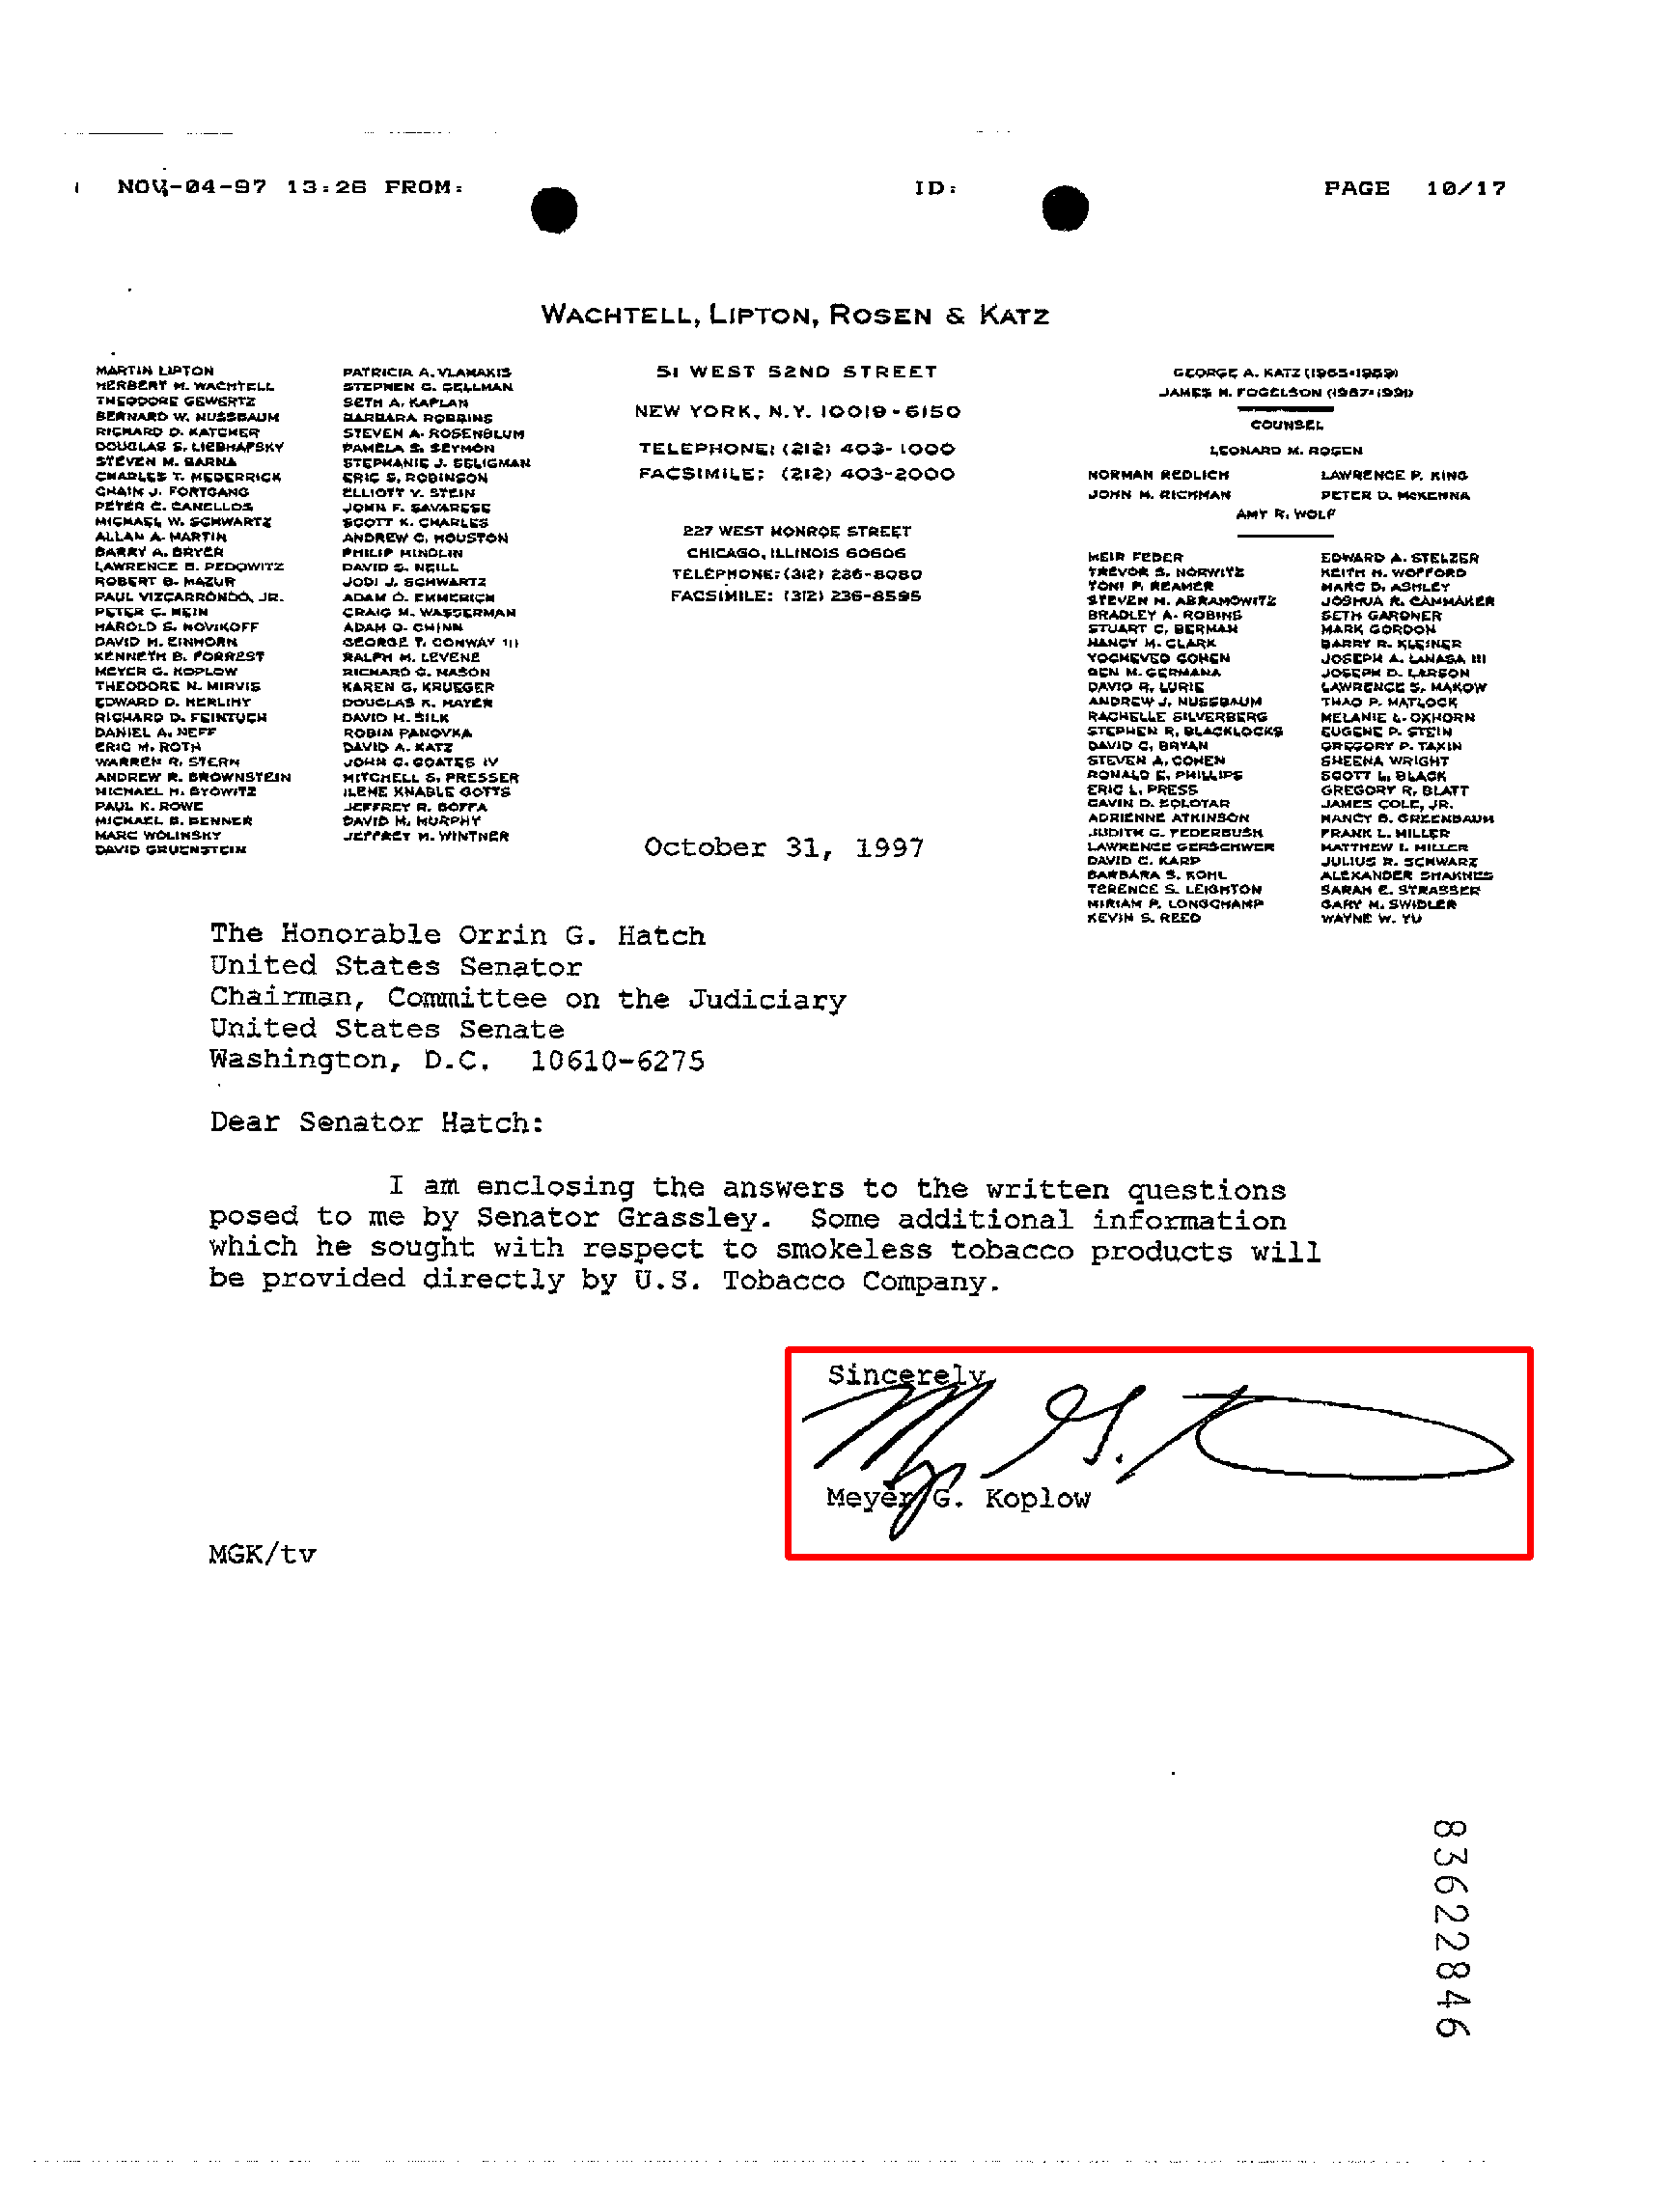

In [8]:
# Drawing bbox using these coordinates on the test image for visualization
original_image = cv2.imread('evaluation/test_image.png')

cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)

PIL.Image.fromarray(original_image)


In [9]:
# Show calculated bbox values for method 1
calculated_1_values_json = pd.read_json('evaluation/calculated_bbox_1.json')
calculated_1_values_json

,gmk15f00.tif,mub51a00.tif,fzh11c00-var.tif,dny38c00_5.tif,was45f00.tif,sfw98c00.tif,lfw39d00.tif,lfv39d00.tif,vbd23f00.tif,mzd01a00.tif,...,yas45f00.tif,cxi59c00_1.tif,wau30a00-page9_16.tif,ihz25e00.tif,arz92e00.tif,gxp01f00_1.tif,azb11c00.tif,aik94f00-page02_2.tif,pvx38c00-page06_6.tif,fbv15e00.tif
0,121,740,1713,205,97,194,353,1564,1526,188,...,106,1067,468,405,1211,114,231,597,825,1898
1,144,1017,573,1485,126,1804,1831,2927,2452,371,...,380,609,891,2399,2040,175,2001,1286,602,76
2,1124,1042,2035,943,1099,562,1219,2407,1818,307,...,1112,1151,1440,868,1856,1033,991,714,1391,2191
3,222,1126,779,1585,249,2032,2109,3071,2656,420,...,421,709,1035,2670,2229,302,2188,1393,765,203


In [10]:
# Show iou results for method 1
iou_1_values_json = pd.read_json('evaluation/iou_1.json')
iou_1_values_json

,suh90a00.tif,amk00a00.tif,mwj41f00.tif,umw13f00.tif,fny38c00-page05_5.tif,fzx20e00-page02_2.tif,vdr55d00.tif,dgw64a00.tif,ciy01a00-page02_2.tif,wau30a00-page9_3.tif,...,lfj35f00.tif,fjx9aa00.tif,lec44c00.tif,wav95e00-page03_3.tif,hfv39d00.tif,jxp35f00.tif,eqp14e00-page02_2.tif,qit05f00-page2_36.tif,qit05f00-page2_22.tif,yrz52d00.tif
ground_truth,"[651, 1123, 851, 1195]","[1234, 2436, 2140, 2809]","[651, 784, 964, 860]","[1355, 1952, 2153, 2126]","[158, 1260, 514, 1360]","[1254, 1614, 1692, 1746]","[511, 1437, 1006, 1552]","[1018, 1586, 1358, 1645]","[636, 756, 849, 811]","[679, 1613, 1346, 1794]",...,"[762, 890, 962, 988]","[146, 1641, 1200, 1854]","[794, 1836, 1486, 2011]","[302, 1888, 833, 2024]","[1635, 2855, 2306, 2965]","[727, 1345, 849, 1423]","[1436, 1413, 2060, 1576]","[592, 729, 934, 875]","[673, 1175, 966, 1284]","[894, 1594, 1295, 1718]"
calculated,"[678, 658, 891, 739]","[39, 3005, 2086, 3071]","[782, 785, 979, 873]","[1836, 1983, 2163, 2134]","[120, 1648, 855, 1882]","[359, 2341, 1417, 2623]","[497, 1433, 1018, 1593]","[175, 1122, 1462, 1342]","[688, 748, 861, 810]","[1444, 2488, 2345, 2665]",...,"[507, 773, 746, 1070]","[139, 1632, 1216, 1868]","[787, 1818, 1166, 2030]","[264, 1920, 1108, 2048]","[981, 791, 1474, 877]","[55, 1149, 1099, 1315]","[1425, 1401, 2073, 1553]","[355, 206, 832, 1059]","[508, 260, 805, 687]","[880, 1579, 1120, 1738]"
intersection,"[678, 1123, 851, 739]","[1234, 3005, 2086, 2809]","[782, 785, 964, 860]","[1836, 1983, 2153, 2126]","[158, 1648, 514, 1360]","[1254, 2341, 1417, 1746]","[511, 1437, 1006, 1552]","[1018, 1586, 1358, 1342]","[688, 756, 849, 810]","[1444, 2488, 1346, 1794]",...,"[762, 890, 746, 988]","[146, 1641, 1200, 1854]","[794, 1836, 1166, 2011]","[302, 1920, 833, 2024]","[1635, 2855, 1474, 877]","[727, 1345, 849, 1315]","[1436, 1413, 2060, 1553]","[592, 729, 832, 875]","[673, 1175, 805, 687]","[894, 1594, 1120, 1718]"
iou_in_percentage,0,0,49.68,31.72,0,0,68.29,0,63.24,0,...,0,88.33,47.75,44.17,0,0,77.41,8.31,0,46.82


## 2. Method 2

### Getting bbox

In [11]:
# The following code is used to find bbox around signature
from method_2.module.loader import Loader
from method_2.module.extractor import Extractor
from method_2.module.boundingBox import BoundingBox

test_image_path = 'evaluation/test_image.png'

loader = Loader()
mask = loader.get_masks(test_image_path)[0]
extractor = Extractor(amplfier=15)
labeled_mask = extractor.extract(mask)
try:
    xmin, ymin, w, h = BoundingBox().run(labeled_mask)
    xmax = xmin + w
    ymax = ymin + h
# handle exception for when no bbox is found
except:
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

print(f'xmin -> {xmin}\n'
      f'ymin -> {ymin}\n'
      f'xmax -> {xmax}\n'
      f'ymax -> {ymax}')

xmin -> 1024
ymin -> 1443
xmax -> 1570
ymax -> 1539


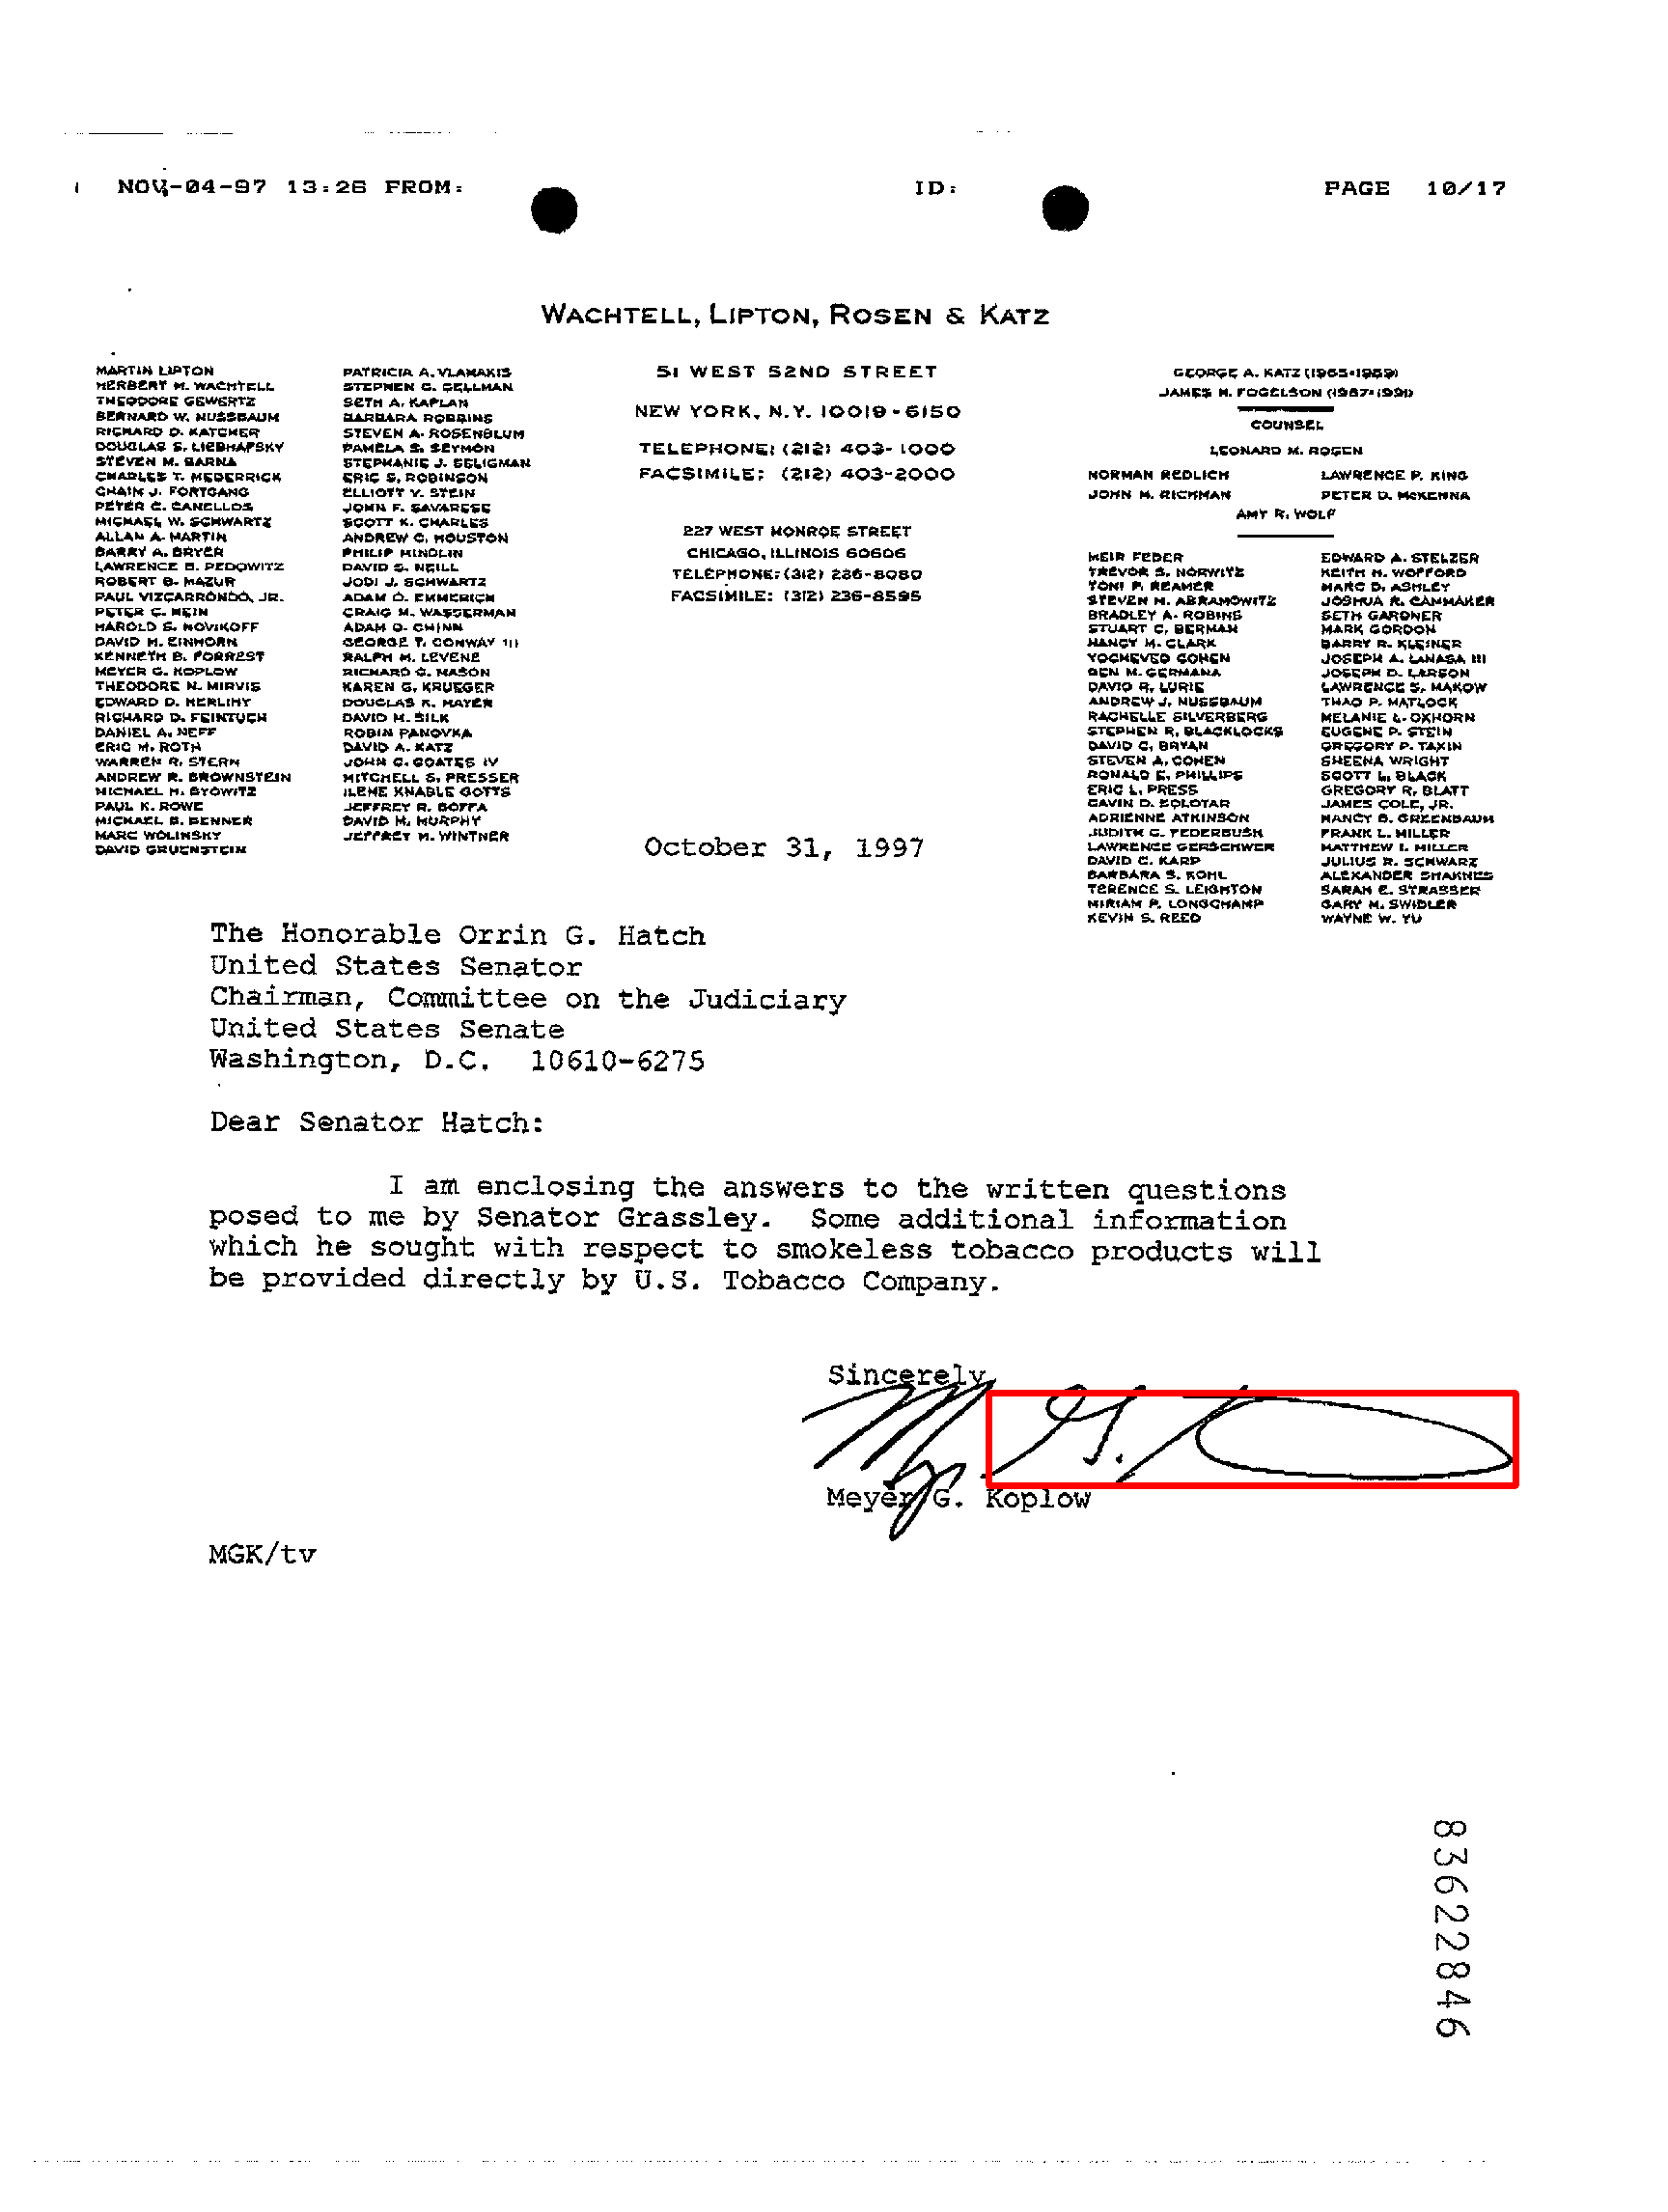

In [12]:
# Drawing bbox using these coordinates on the test image for visualization
original_image = cv2.imread('evaluation/test_image.png')

cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)

PIL.Image.fromarray(original_image)

In [13]:
# Show calculated bbox values for method 2
calculated_2_values_json = pd.read_json('evaluation/calculated_bbox_2.json')
calculated_2_values_json

,gmk15f00.tif,mub51a00.tif,fzh11c00-var.tif,dny38c00_5.tif,was45f00.tif,sfw98c00.tif,lfw39d00.tif,lfv39d00.tif,vbd23f00.tif,mzd01a00.tif,...,yas45f00.tif,cxi59c00_1.tif,wau30a00-page9_16.tif,ihz25e00.tif,arz92e00.tif,gxp01f00_1.tif,azb11c00.tif,aik94f00-page02_2.tif,pvx38c00-page06_6.tif,fbv15e00.tif
0,802,762,1881,226,119,227,391,1589,891,0,...,121,378,493,443,1113,135,260,0,851,1965
1,1102,1039,613,1506,148,1837,1869,2954,1148,0,...,395,1663,916,2437,158,116,2030,0,634,99
2,961,1027,2020,605,1084,547,1204,2392,1305,0,...,1097,617,1425,853,1399,415,976,0,1376,2109
3,1178,1111,764,1570,225,2017,2094,3056,1424,0,...,406,1803,1020,2655,334,177,2173,0,745,188


In [14]:
# Show iou results for method 2
iou_2_values_json = pd.read_json('evaluation/iou_2.json')
iou_2_values_json

,suh90a00.tif,amk00a00.tif,mwj41f00.tif,umw13f00.tif,fny38c00-page05_5.tif,fzx20e00-page02_2.tif,vdr55d00.tif,dgw64a00.tif,ciy01a00-page02_2.tif,wau30a00-page9_3.tif,...,lfj35f00.tif,fjx9aa00.tif,lec44c00.tif,wav95e00-page03_3.tif,hfv39d00.tif,jxp35f00.tif,eqp14e00-page02_2.tif,qit05f00-page2_36.tif,qit05f00-page2_22.tif,yrz52d00.tif
ground_truth,"[651, 1123, 851, 1195]","[1234, 2436, 2140, 2809]","[651, 784, 964, 860]","[1355, 1952, 2153, 2126]","[158, 1260, 514, 1360]","[1254, 1614, 1692, 1746]","[511, 1437, 1006, 1552]","[1018, 1586, 1358, 1645]","[636, 756, 849, 811]","[679, 1613, 1346, 1794]",...,"[762, 890, 962, 988]","[146, 1641, 1200, 1854]","[794, 1836, 1486, 2011]","[302, 1888, 833, 2024]","[1635, 2855, 2306, 2965]","[727, 1345, 849, 1423]","[1436, 1413, 2060, 1576]","[592, 729, 934, 875]","[673, 1175, 966, 1284]","[894, 1594, 1295, 1718]"
calculated,"[0, 0, 0, 0]","[56, 3022, 2071, 3056]","[0, 0, 0, 0]","[1126, 167, 1491, 354]","[198, 1549, 906, 1622]","[493, 2380, 1402, 2608]","[2200, 1492, 2412, 1682]","[308, 514, 951, 683]","[0, 0, 0, 0]","[578, 1649, 1340, 1800]",...,"[603, 1089, 993, 1206]","[169, 1662, 806, 1810]","[819, 1850, 1151, 2015]","[290, 2194, 1094, 2297]","[1637, 2872, 2299, 2959]","[301, 1338, 1080, 1419]","[1451, 1427, 2058, 1538]","[483, 261, 815, 883]","[602, 296, 787, 584]","[906, 1601, 983, 1718]"
intersection,"[651, 1123, 0, 0]","[1234, 3022, 2071, 2809]","[651, 784, 0, 0]","[1355, 1952, 1491, 354]","[198, 1549, 514, 1360]","[1254, 2380, 1402, 1746]","[2200, 1492, 1006, 1552]","[1018, 1586, 951, 683]","[636, 756, 0, 0]","[679, 1649, 1340, 1794]",...,"[762, 1089, 962, 988]","[169, 1662, 806, 1810]","[819, 1850, 1151, 2011]","[302, 2194, 833, 2024]","[1637, 2872, 2299, 2959]","[727, 1345, 849, 1419]","[1451, 1427, 2058, 1538]","[592, 729, 815, 875]","[673, 1175, 787, 584]","[906, 1601, 983, 1718]"
iou_in_percentage,0,0,0,0,0,0,0,0,0,68.49,...,0,41.99,43.66,0,78.03,14.2,66.24,14.54,0,18.12


## 3. Method 3

### Getting bbox

In [16]:
# The following code is used to find bbox around signature
import cv2
from method_1.module.signature_removal import Signature_removal
from method_2.module.loader import Loader
from method_2.module.extractor import Extractor
from method_2.module.boundingBox import BoundingBox

# First calculate bbox using method 2, if all coordinates are 0 then use method 1

test_image_path = 'evaluation/test_image.png'

# use method 2
loader = Loader()
mask = loader.get_masks(test_image_path)[0]
extractor = Extractor(amplfier=15)
labeled_mask = extractor.extract(mask)
try:
    xmin, ymin, w, h = BoundingBox().run(labeled_mask)
    xmax = xmin + w
    ymax = ymin + h
# handle exception for when no bbox is found
except:
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

# use method 1
if (xmin and ymin and xmax and ymax) == 0:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    xmin, ymin, xmax, ymax = Signature_removal(image).get_signature_bbox()

# Convert from numpy int64 to integer for JSON serialization
xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

print(f'xmin -> {xmin}\n'
      f'ymin -> {ymin}\n'
      f'xmax -> {xmax}\n'
      f'ymax -> {ymax}')

xmin -> 1024
ymin -> 1443
xmax -> 1570
ymax -> 1539


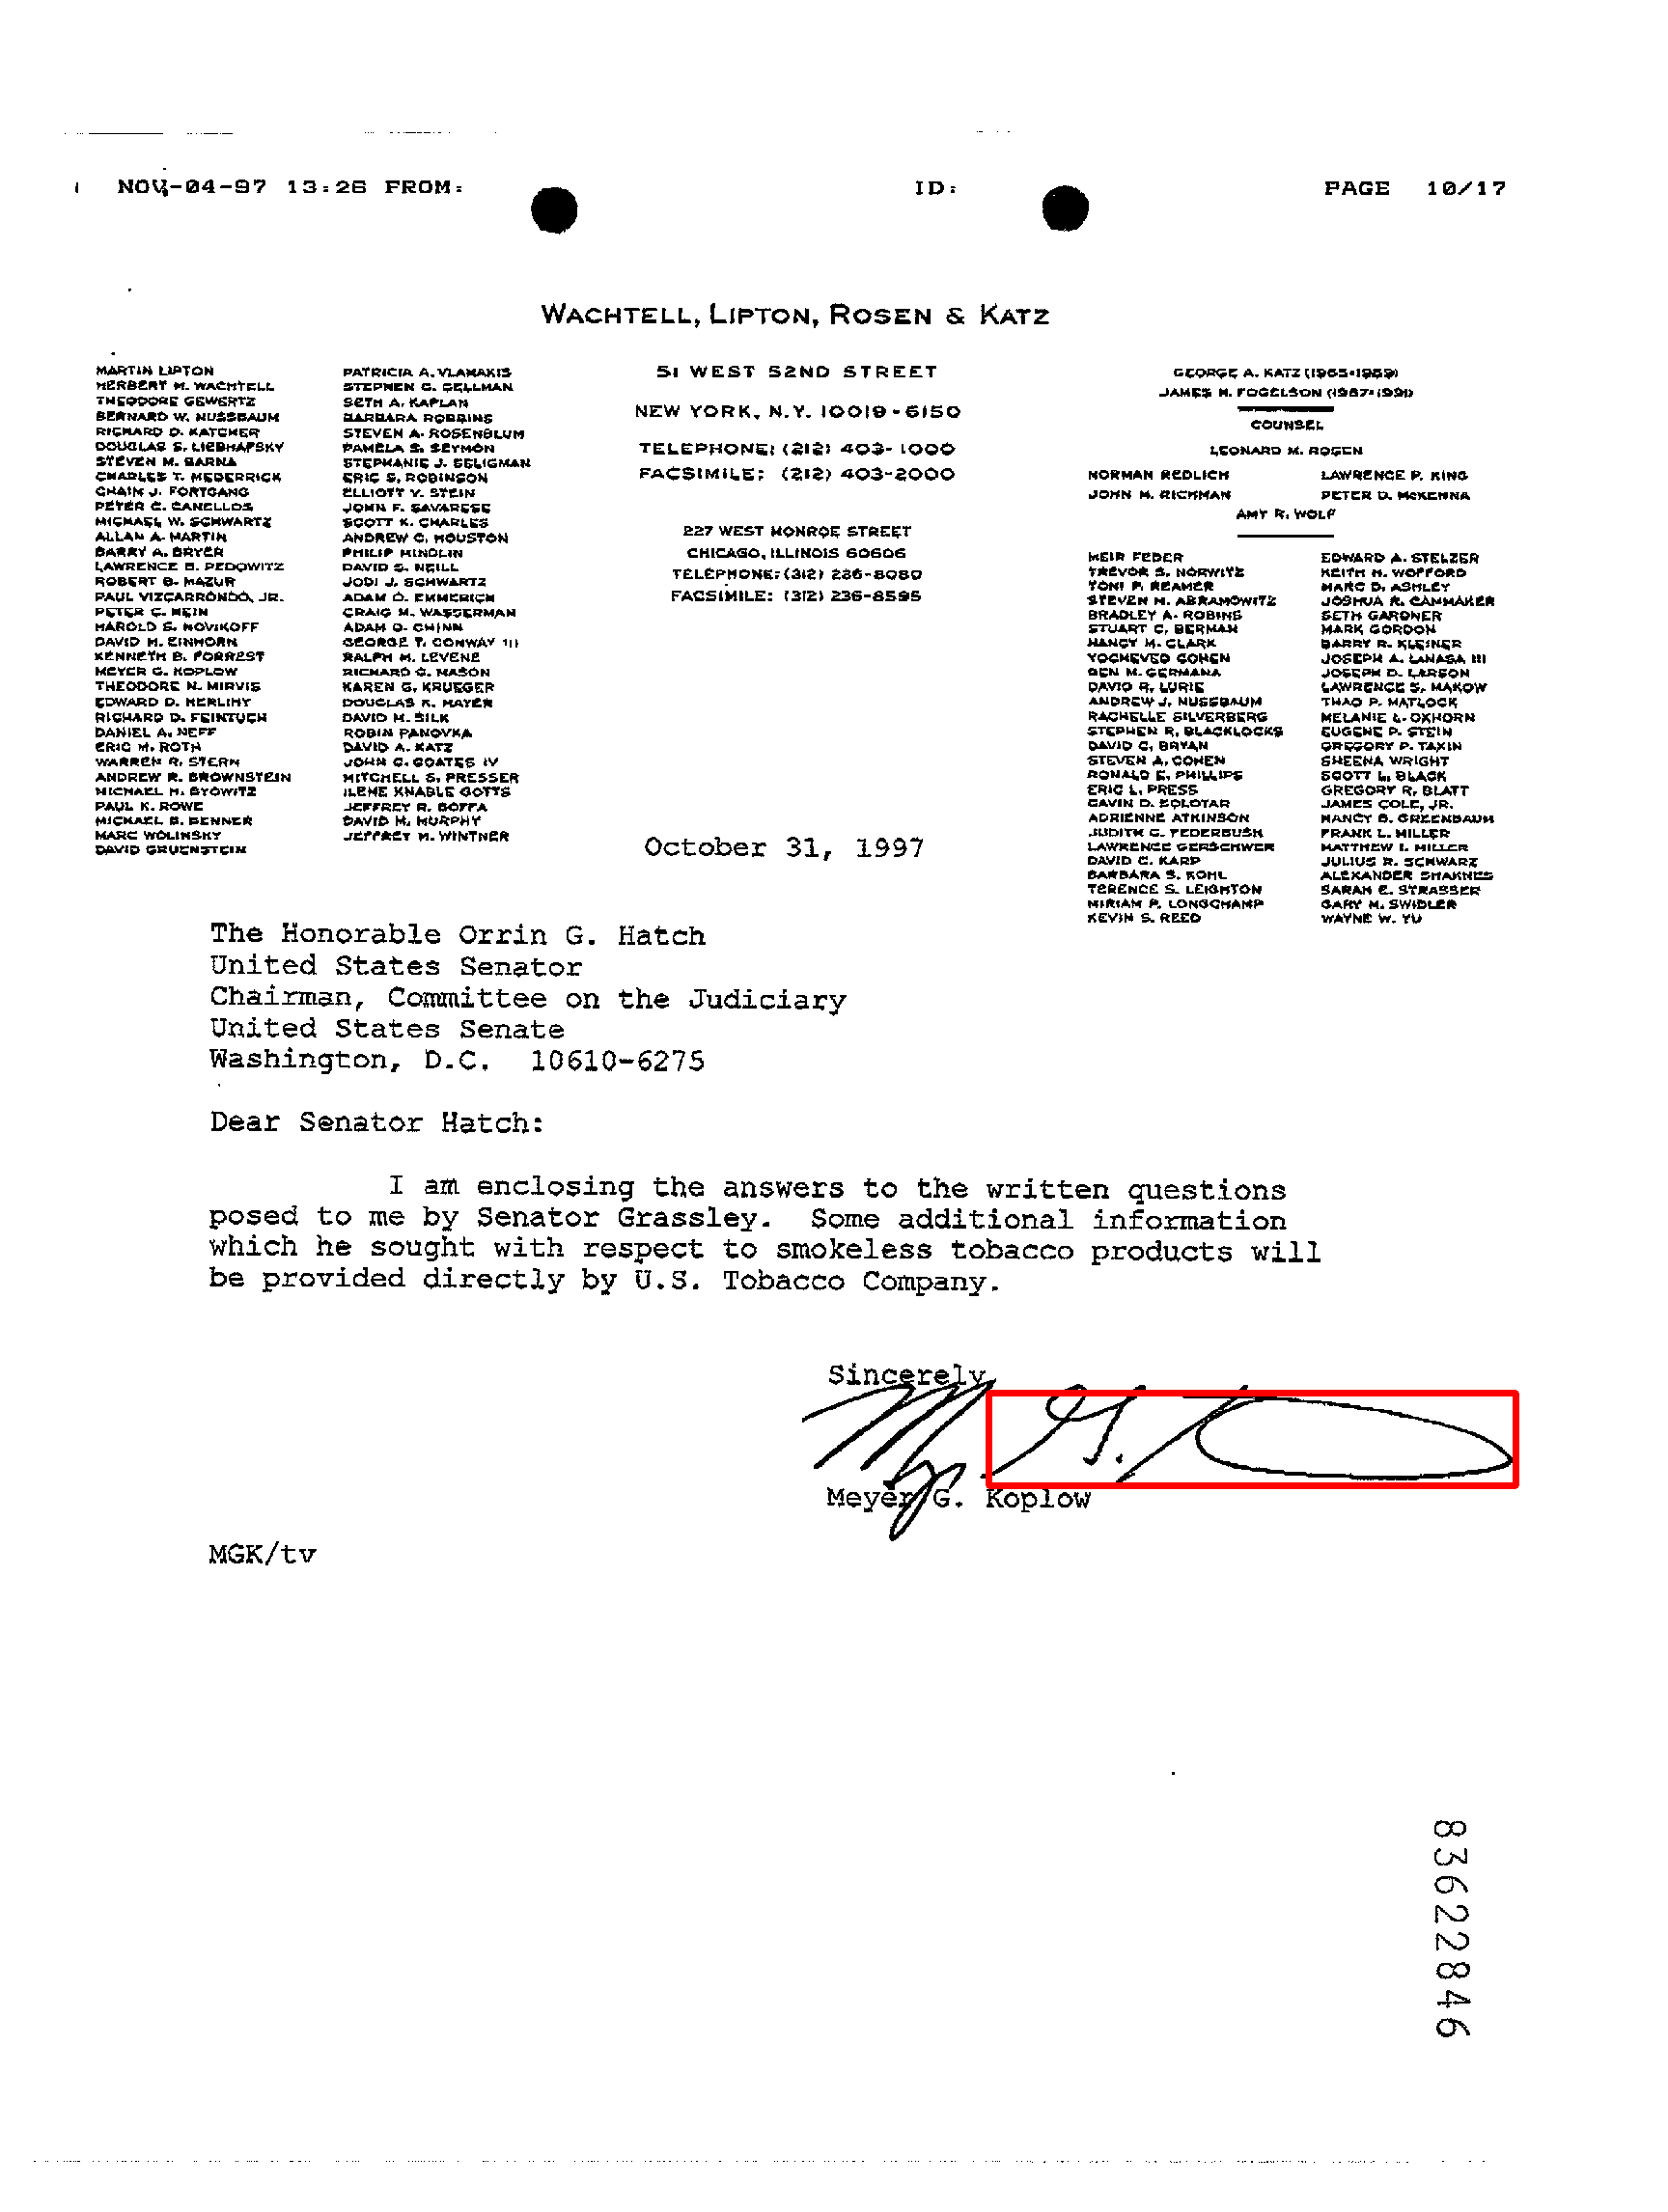

In [17]:
# Drawing bbox using these coordinates on the test image for visualization
original_image = cv2.imread('evaluation/test_image.png')

cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)

PIL.Image.fromarray(original_image)

In [18]:
# Show calculated bbox values for method 3
calculated_3_values_json = pd.read_json('evaluation/calculated_bbox_3.json')
calculated_3_values_json

,gmk15f00.tif,mub51a00.tif,fzh11c00-var.tif,dny38c00_5.tif,was45f00.tif,sfw98c00.tif,lfw39d00.tif,lfv39d00.tif,vbd23f00.tif,mzd01a00.tif,...,yas45f00.tif,cxi59c00_1.tif,wau30a00-page9_16.tif,ihz25e00.tif,arz92e00.tif,gxp01f00_1.tif,azb11c00.tif,aik94f00-page02_2.tif,pvx38c00-page06_6.tif,fbv15e00.tif
0,802,762,1881,226,119,227,391,1589,891,188,...,121,378,493,443,1113,135,260,597,851,1965
1,1102,1039,613,1506,148,1837,1869,2954,1148,371,...,395,1663,916,2437,158,116,2030,1286,634,99
2,961,1027,2020,605,1084,547,1204,2392,1305,307,...,1097,617,1425,853,1399,415,976,714,1376,2109
3,1178,1111,764,1570,225,2017,2094,3056,1424,420,...,406,1803,1020,2655,334,177,2173,1393,745,188


In [19]:
# Show iou results for method 3
iou_3_values_json = pd.read_json('evaluation/iou_3.json')
iou_3_values_json

,suh90a00.tif,amk00a00.tif,mwj41f00.tif,umw13f00.tif,fny38c00-page05_5.tif,fzx20e00-page02_2.tif,vdr55d00.tif,dgw64a00.tif,ciy01a00-page02_2.tif,wau30a00-page9_3.tif,...,lfj35f00.tif,fjx9aa00.tif,lec44c00.tif,wav95e00-page03_3.tif,hfv39d00.tif,jxp35f00.tif,eqp14e00-page02_2.tif,qit05f00-page2_36.tif,qit05f00-page2_22.tif,yrz52d00.tif
ground_truth,"[651, 1123, 851, 1195]","[1234, 2436, 2140, 2809]","[651, 784, 964, 860]","[1355, 1952, 2153, 2126]","[158, 1260, 514, 1360]","[1254, 1614, 1692, 1746]","[511, 1437, 1006, 1552]","[1018, 1586, 1358, 1645]","[636, 756, 849, 811]","[679, 1613, 1346, 1794]",...,"[762, 890, 962, 988]","[146, 1641, 1200, 1854]","[794, 1836, 1486, 2011]","[302, 1888, 833, 2024]","[1635, 2855, 2306, 2965]","[727, 1345, 849, 1423]","[1436, 1413, 2060, 1576]","[592, 729, 934, 875]","[673, 1175, 966, 1284]","[894, 1594, 1295, 1718]"
calculated,"[678, 658, 891, 739]","[56, 3022, 2071, 3056]","[782, 785, 979, 873]","[1126, 167, 1491, 354]","[198, 1549, 906, 1622]","[493, 2380, 1402, 2608]","[2200, 1492, 2412, 1682]","[308, 514, 951, 683]","[688, 748, 861, 810]","[578, 1649, 1340, 1800]",...,"[603, 1089, 993, 1206]","[169, 1662, 806, 1810]","[819, 1850, 1151, 2015]","[290, 2194, 1094, 2297]","[1637, 2872, 2299, 2959]","[301, 1338, 1080, 1419]","[1451, 1427, 2058, 1538]","[483, 261, 815, 883]","[602, 296, 787, 584]","[906, 1601, 983, 1718]"
intersection,"[678, 1123, 851, 739]","[1234, 3022, 2071, 2809]","[782, 785, 964, 860]","[1355, 1952, 1491, 354]","[198, 1549, 514, 1360]","[1254, 2380, 1402, 1746]","[2200, 1492, 1006, 1552]","[1018, 1586, 951, 683]","[688, 756, 849, 810]","[679, 1649, 1340, 1794]",...,"[762, 1089, 962, 988]","[169, 1662, 806, 1810]","[819, 1850, 1151, 2011]","[302, 2194, 833, 2024]","[1637, 2872, 2299, 2959]","[727, 1345, 849, 1419]","[1451, 1427, 2058, 1538]","[592, 729, 815, 875]","[673, 1175, 787, 584]","[906, 1601, 983, 1718]"
iou_in_percentage,0,0,49.68,0,0,0,0,0,63.24,68.49,...,0,41.99,43.66,0,78.03,14.2,66.24,14.54,0,18.12


## 4. Method 4

### Getting bbox

In [20]:
# The following code is used to find bbox around signature
import cv2
from method_4.module.core import extract_signature
import joblib
import numpy as np

test_image = 'evaluation/test_image.png'

# decision tree model
model = joblib.load("method_4/module/models/decision-tree.pkl")
clf = model

im = cv2.imread(test_image, 0)
mask = extract_signature(im, clf, preprocess=True)

im = cv2.imread(test_image)
im[np.where(mask==255)] = (0, 0, 255)

# find bounding box on image
points = np.argwhere(mask==255)  # find where the black pixels are
points = np.fliplr(points)       # store them in x,y coordinates instead of row,col indices
x, y, w, h = cv2.boundingRect(points)  # create a rectangle around those points
xmin = x
ymin = y
xmax = x + w
ymax = y + h

print(f'xmin -> {xmin}\n'
      f'ymin -> {ymin}\n'
      f'xmax -> {xmax}\n'
      f'ymax -> {ymax}')

/Users/veersingh/opt/anaconda3/envs/signature-detection-and-extraction/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


xmin -> 864
ymin -> 1418
xmax -> 1569
ymax -> 1597


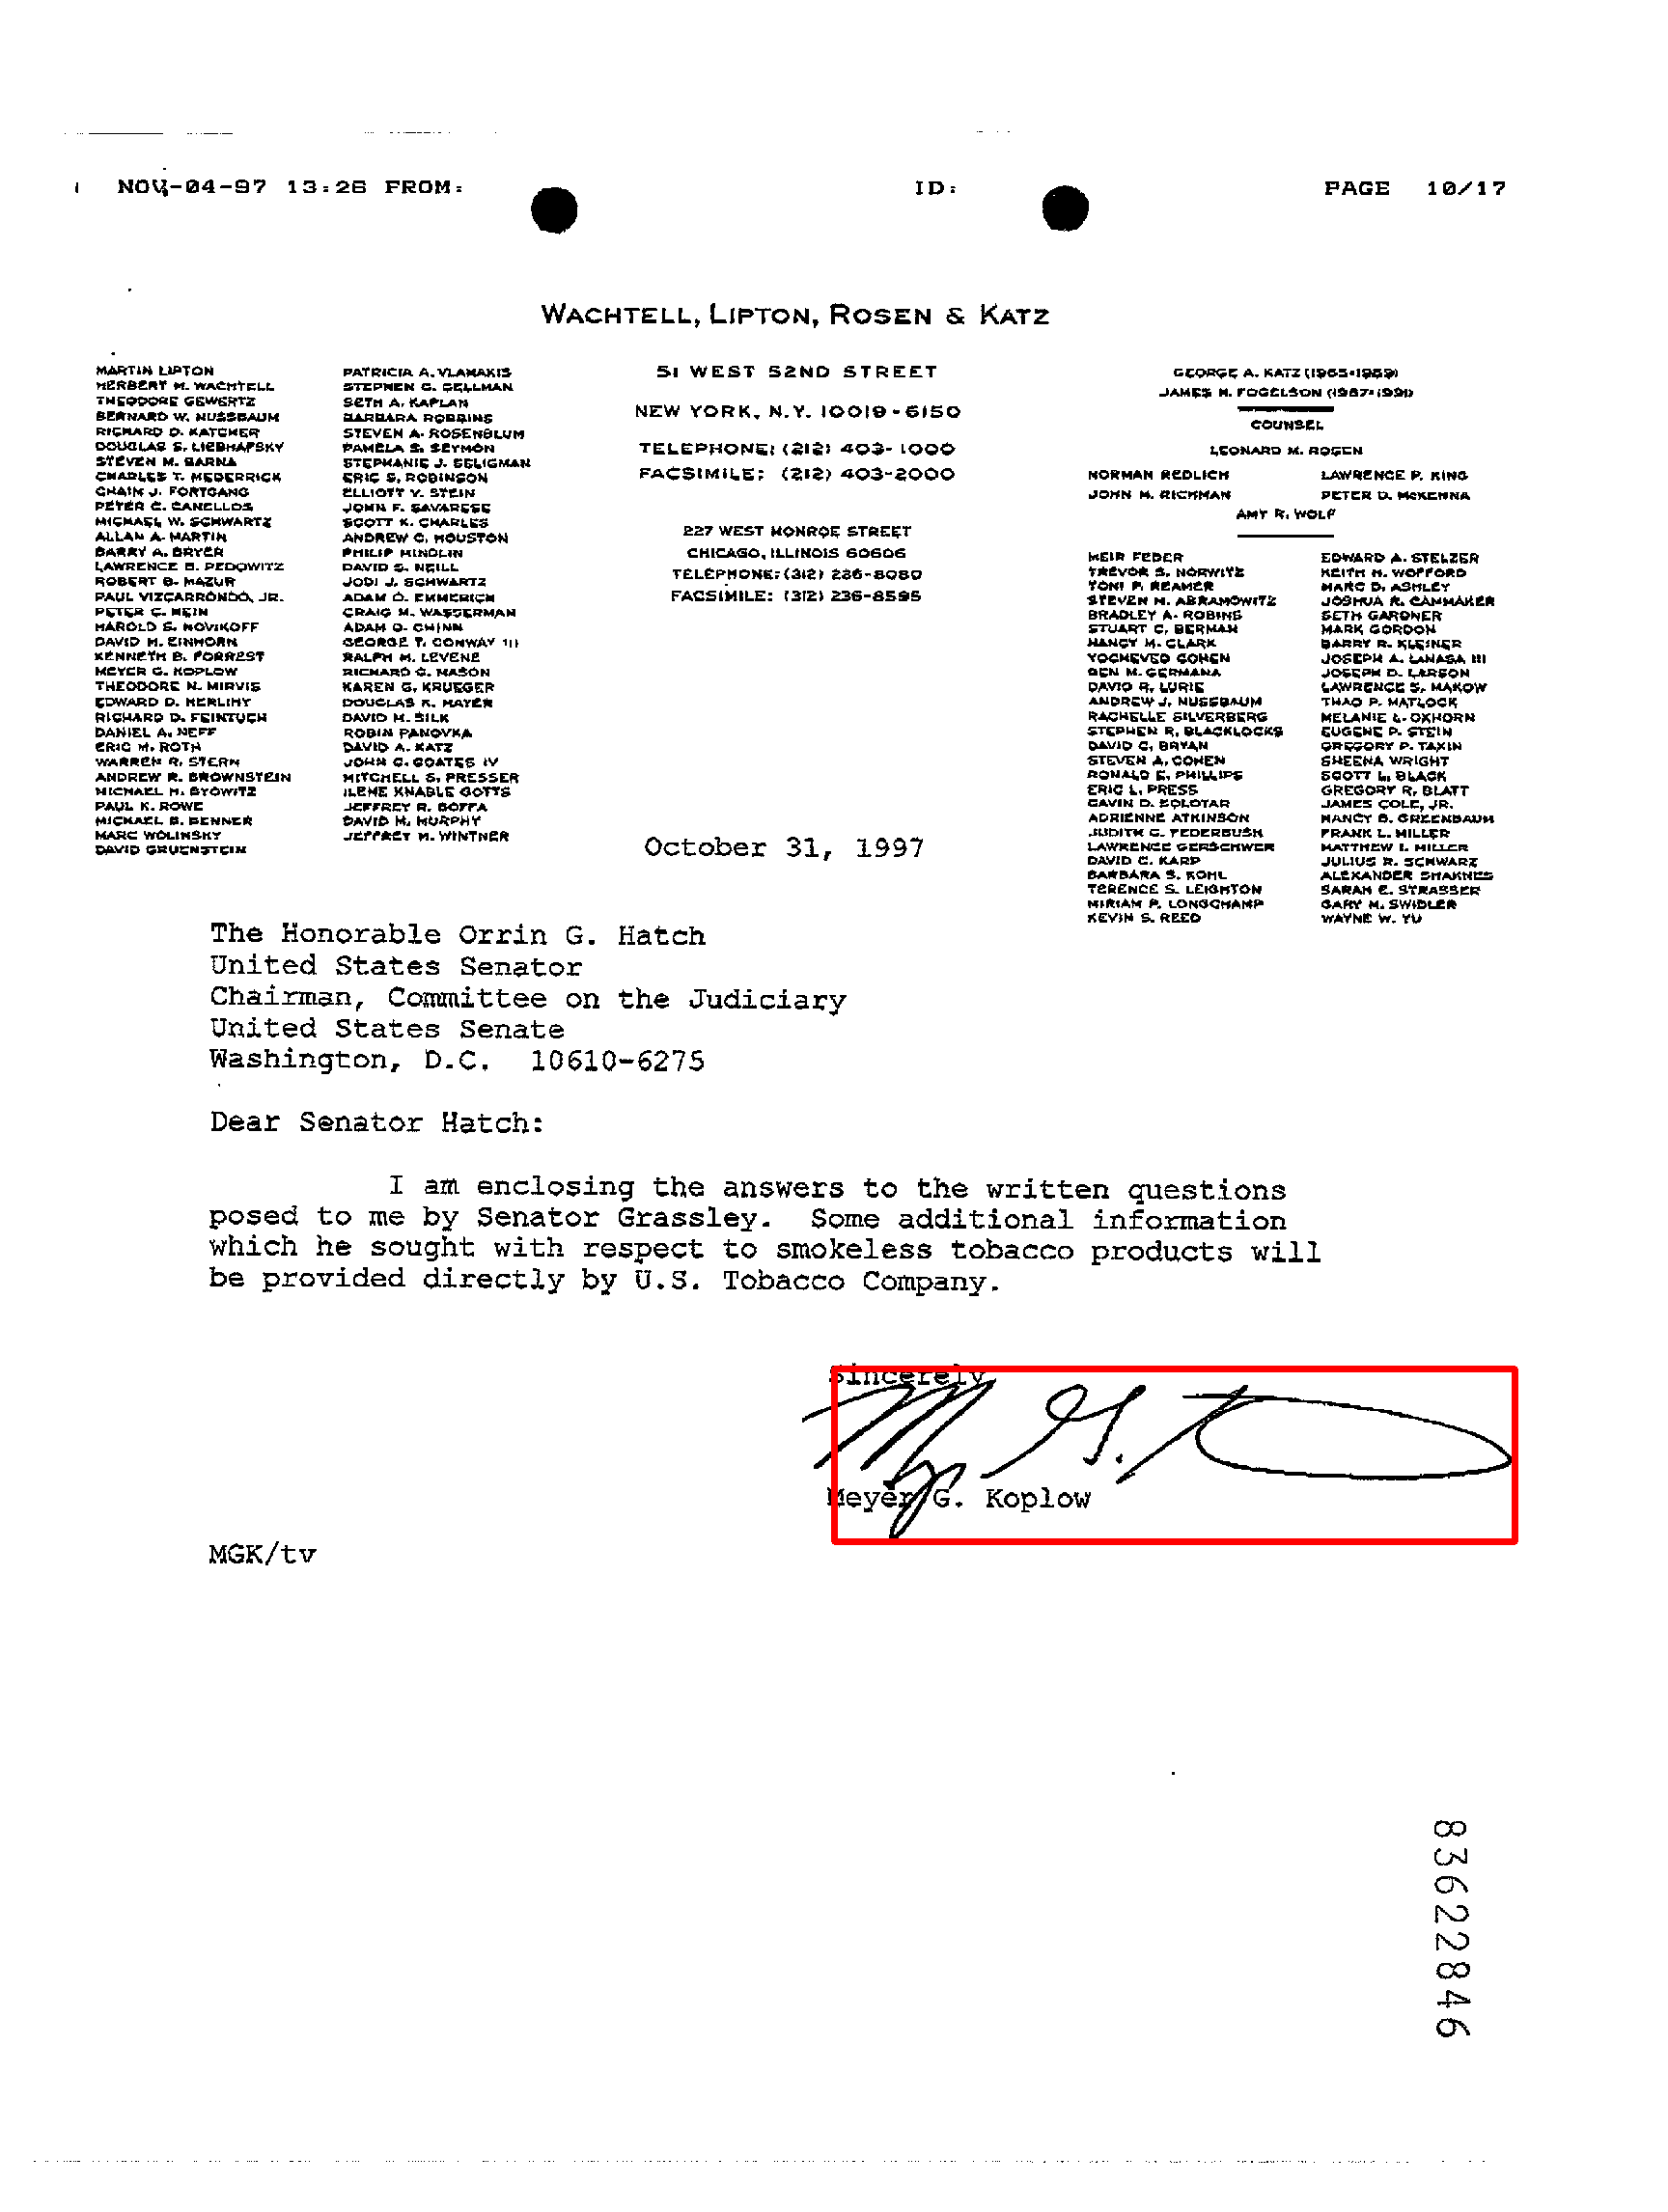

In [21]:
# Drawing bbox using these coordinates on the test image for visualization
original_image = cv2.imread('evaluation/test_image.png')

cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)

PIL.Image.fromarray(original_image)

In [22]:
# Show calculated bbox values for method 4
calculated_4_values_json = pd.read_json('evaluation/calculated_bbox_4.json')
calculated_4_values_json

,gmk15f00.tif,mub51a00.tif,fzh11c00-var.tif,dny38c00_5.tif,was45f00.tif,sfw98c00.tif,lfw39d00.tif,lfv39d00.tif,vbd23f00.tif,mzd01a00.tif,...,yas45f00.tif,cxi59c00_1.tif,wau30a00-page9_16.tif,ihz25e00.tif,arz92e00.tif,gxp01f00_1.tif,azb11c00.tif,aik94f00-page02_2.tif,pvx38c00-page06_6.tif,fbv15e00.tif
0,735,625,0,991,720,977,1318,1579,1272,0,...,732,0,1456,1305,1280,0,0,0,0,1312
1,1095,1032,0,1453,813,1320,1654,1635,2467,0,...,934,0,1729,1758,1732,0,0,0,0,2058
2,960,1026,0,1191,855,1216,2098,2350,2327,0,...,837,0,2371,1787,2370,0,0,0,0,2401
3,1177,1112,0,1544,886,1521,2402,3055,2900,0,...,1001,0,1997,2780,3009,0,0,0,0,2691


In [23]:
# Show iou results for method 4
iou_4_values_json = pd.read_json('evaluation/iou_4.json')
iou_4_values_json

,suh90a00.tif,amk00a00.tif,mwj41f00.tif,umw13f00.tif,fny38c00-page05_5.tif,fzx20e00-page02_2.tif,vdr55d00.tif,dgw64a00.tif,ciy01a00-page02_2.tif,wau30a00-page9_3.tif,...,lfj35f00.tif,fjx9aa00.tif,lec44c00.tif,wav95e00-page03_3.tif,hfv39d00.tif,jxp35f00.tif,eqp14e00-page02_2.tif,qit05f00-page2_36.tif,qit05f00-page2_22.tif,yrz52d00.tif
ground_truth,"[651, 1123, 851, 1195]","[1234, 2436, 2140, 2809]","[651, 784, 964, 860]","[1355, 1952, 2153, 2126]","[158, 1260, 514, 1360]","[1254, 1614, 1692, 1746]","[511, 1437, 1006, 1552]","[1018, 1586, 1358, 1645]","[636, 756, 849, 811]","[679, 1613, 1346, 1794]",...,"[762, 890, 962, 988]","[146, 1641, 1200, 1854]","[794, 1836, 1486, 2011]","[302, 1888, 833, 2024]","[1635, 2855, 2306, 2965]","[727, 1345, 849, 1423]","[1436, 1413, 2060, 1576]","[592, 729, 934, 875]","[673, 1175, 966, 1284]","[894, 1594, 1295, 1718]"
calculated,"[0, 0, 0, 0]","[1359, 2539, 1621, 2630]","[652, 793, 957, 857]","[1357, 1956, 2147, 2118]","[965, 1495, 1183, 1888]","[1347, 1647, 2319, 3233]","[2360, 2961, 2396, 3008]","[864, 1144, 1355, 1650]","[0, 0, 0, 0]","[1423, 2184, 2329, 2649]",...,"[600, 925, 992, 1226]","[1294, 1759, 2112, 2734]","[864, 1833, 1014, 2014]","[1388, 1948, 1419, 2022]","[1507, 1706, 2298, 2958]","[733, 1185, 794, 1417]","[0, 0, 0, 0]","[600, 787, 689, 874]","[673, 1176, 965, 1281]","[895, 1594, 1254, 1722]"
intersection,"[651, 1123, 0, 0]","[1359, 2539, 1621, 2630]","[652, 793, 957, 857]","[1357, 1956, 2147, 2118]","[965, 1495, 514, 1360]","[1347, 1647, 1692, 1746]","[2360, 2961, 1006, 1552]","[1018, 1586, 1355, 1645]","[636, 756, 0, 0]","[1423, 2184, 1346, 1794]",...,"[762, 925, 962, 988]","[1294, 1759, 1200, 1854]","[864, 1836, 1014, 2011]","[1388, 1948, 833, 2022]","[1635, 2855, 2298, 2958]","[733, 1345, 794, 1417]","[1436, 1413, 0, 0]","[600, 787, 689, 874]","[673, 1176, 965, 1281]","[895, 1594, 1254, 1718]"
iou_in_percentage,0,7.06,82.06,92.17,0,2.18,0,8,0,0,...,10.08,0,21.52,0,6.86,22.78,0,15.51,96,87.01


## 5. Method 5

### Getting bbox

In [26]:
# The following code is used to find bbox around signature
import cv2
from method_4.module.core import extract_signature
import joblib
import numpy as np
from method_1.module.signature_removal import Signature_removal

test_image = 'evaluation/test_image.png'

# decision tree model
model = joblib.load("method_5/models/decision-tree.pkl")
clf = model

im = cv2.imread(test_image, 0)
mask = extract_signature(im, clf, preprocess=True)

im = cv2.imread(test_image)
im[np.where(mask == 255)] = (0, 0, 255)

# find bounding box on image
points = np.argwhere(mask == 255)
points = np.fliplr(points)
x, y, w, h = cv2.boundingRect(points)
xmin = x
ymin = y
xmax = x + w
ymax = y + h

# If found coordinats are 0, use method 1
if xmin == ymin == xmax == ymax == 0:
    image = cv2.imread(input_image, cv2.IMREAD_GRAYSCALE)
    xmin, ymin, xmax, ymax = Signature_removal(image).get_signature_bbox()

print(f'xmin -> {xmin}\n'
      f'ymin -> {ymin}\n'
      f'xmax -> {xmax}\n'
      f'ymax -> {ymax}')

/Users/veersingh/opt/anaconda3/envs/signature-detection-and-extraction/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


xmin -> 864
ymin -> 1418
xmax -> 1569
ymax -> 1597


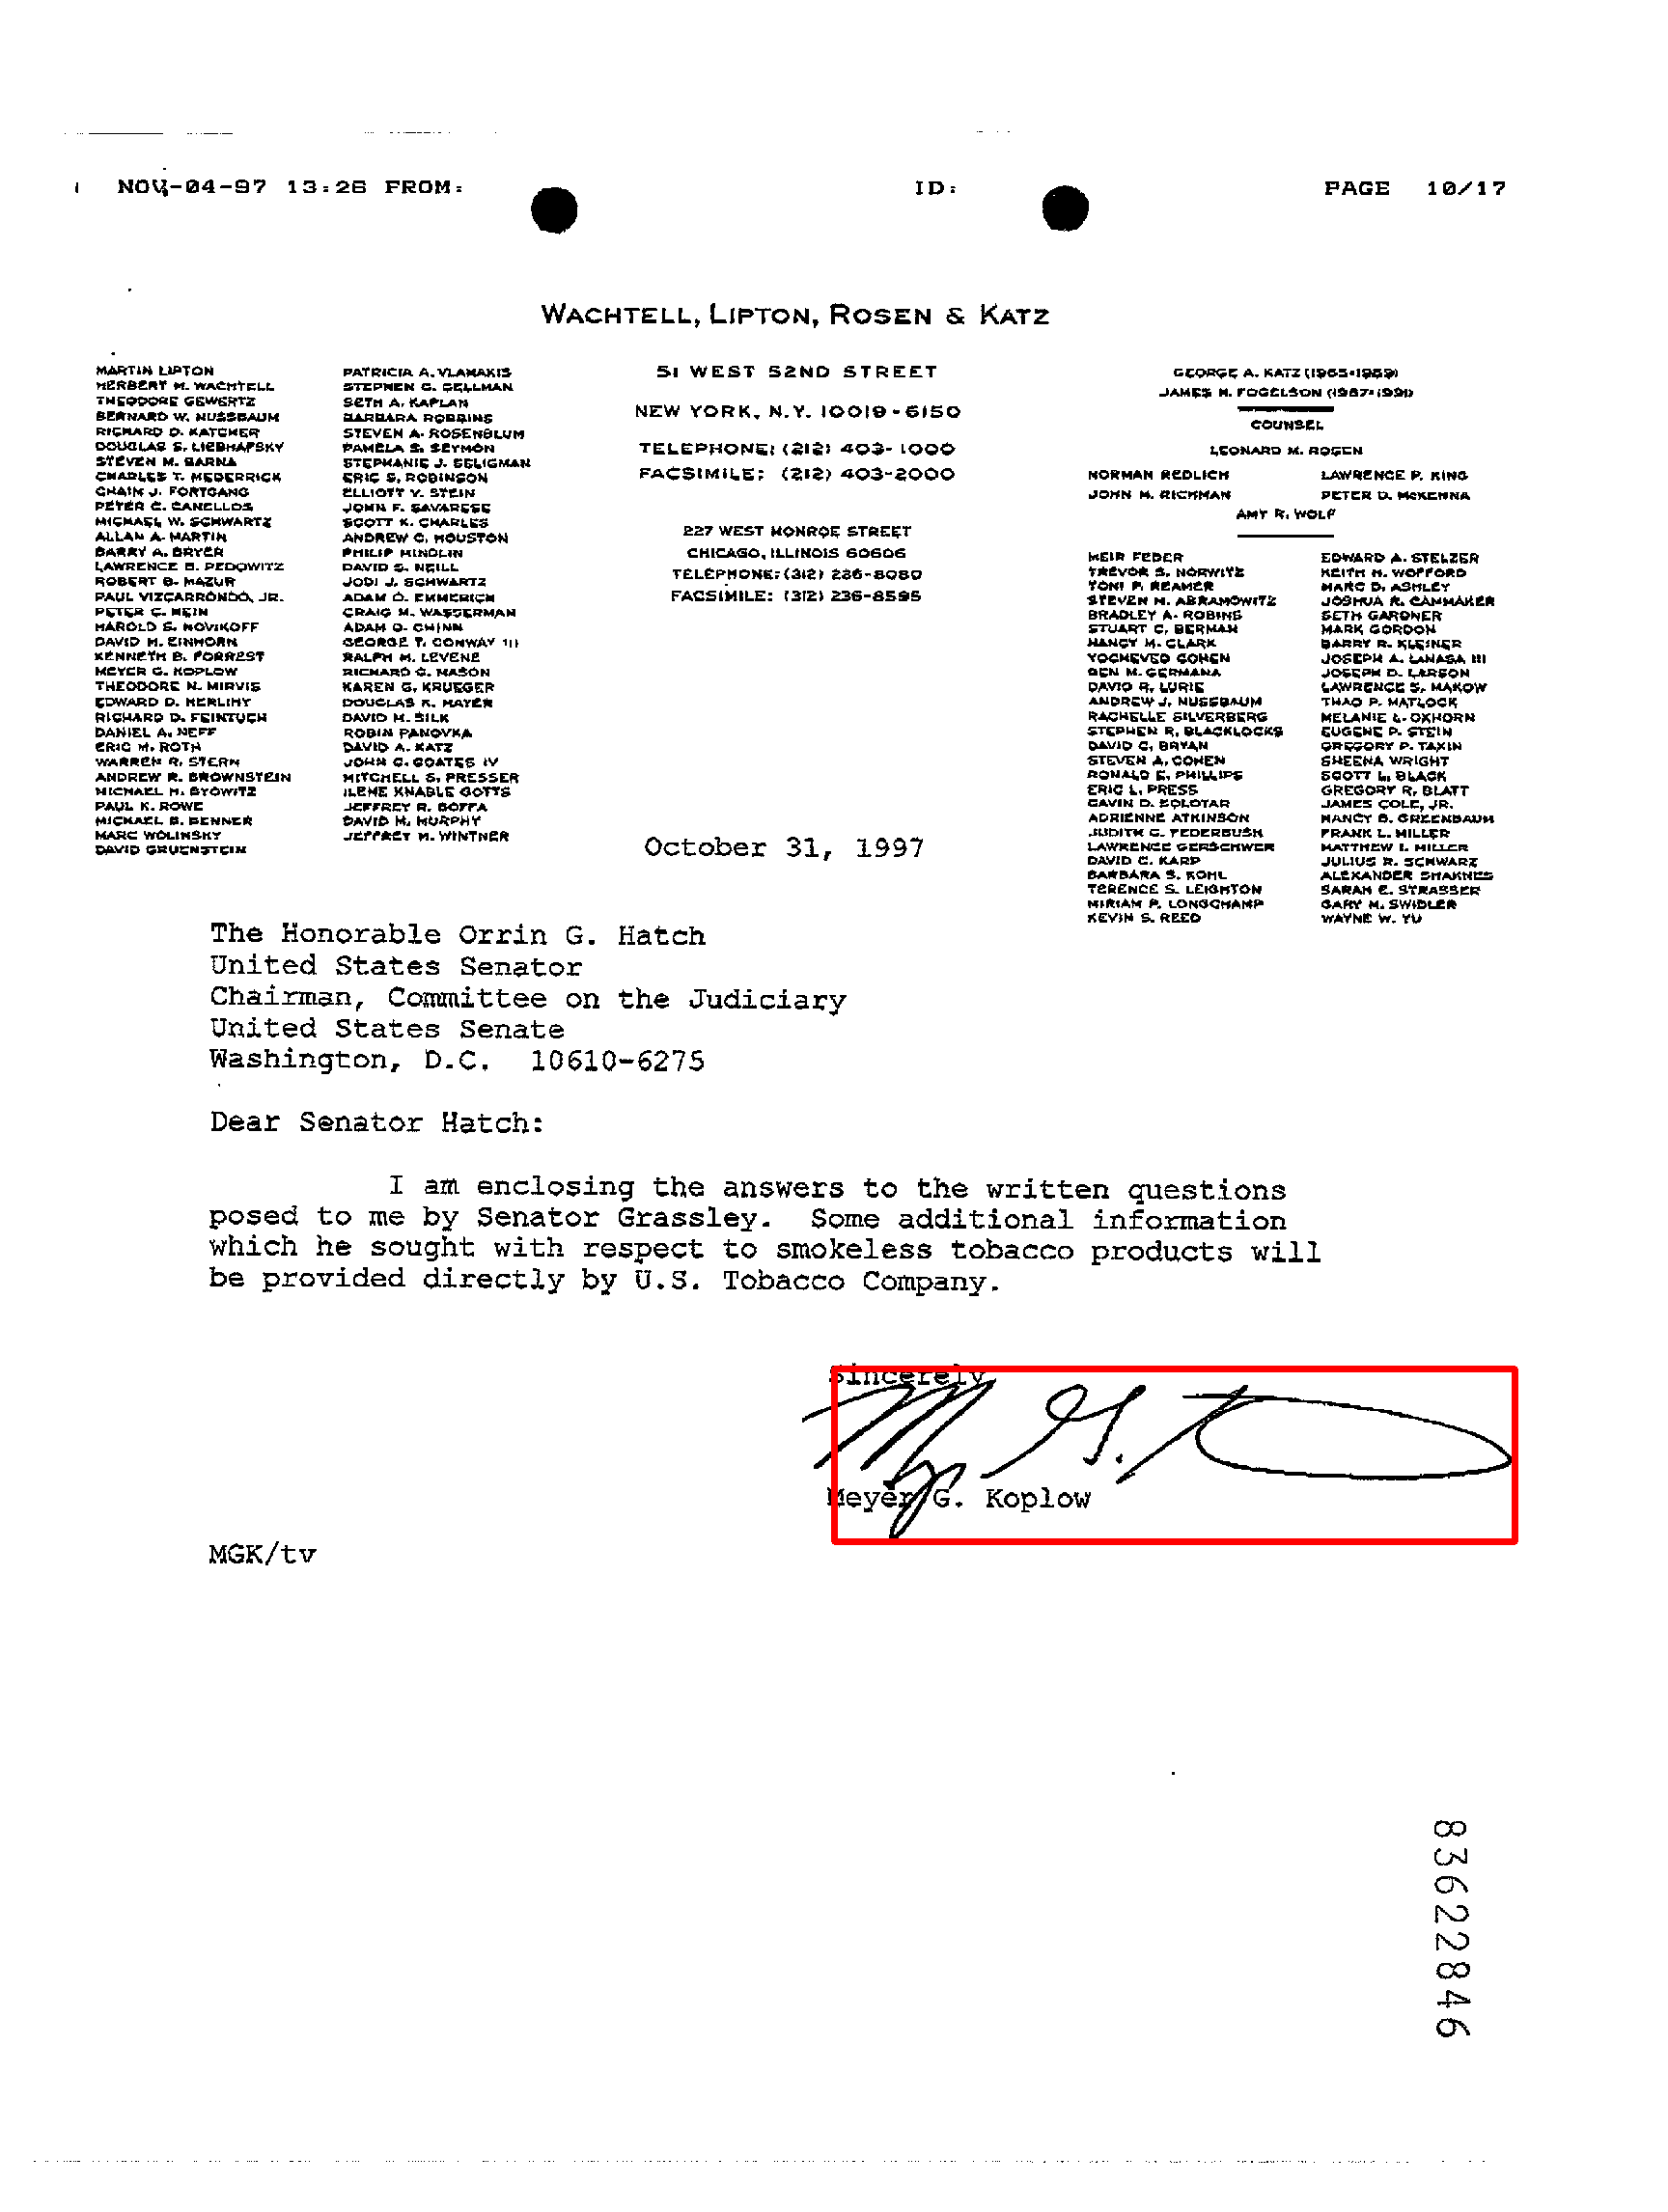

In [27]:
# Drawing bbox using these coordinates on the test image for visualization
original_image = cv2.imread('evaluation/test_image.png')

cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)

PIL.Image.fromarray(original_image)

In [28]:
# Show calculated bbox values for method 5
calculated_5_values_json = pd.read_json('evaluation/calculated_bbox_5.json')
calculated_5_values_json

,gmk15f00.tif,mub51a00.tif,fzh11c00-var.tif,dny38c00_5.tif,was45f00.tif,sfw98c00.tif,lfw39d00.tif,lfv39d00.tif,vbd23f00.tif,mzd01a00.tif,...,yas45f00.tif,cxi59c00_1.tif,wau30a00-page9_16.tif,ihz25e00.tif,arz92e00.tif,gxp01f00_1.tif,azb11c00.tif,aik94f00-page02_2.tif,pvx38c00-page06_6.tif,fbv15e00.tif
0,735,625,1713,991,720,977,1318,1579,1272,188,...,732,1067,1456,1305,1280,114,231,597,825,1312
1,1095,1032,573,1453,813,1320,1654,1635,2467,371,...,934,609,1729,1758,1732,175,2001,1286,602,2058
2,960,1026,2035,1191,855,1216,2098,2350,2327,307,...,837,1151,2371,1787,2370,1033,991,714,1391,2401
3,1177,1112,779,1544,886,1521,2402,3055,2900,420,...,1001,709,1997,2780,3009,302,2188,1393,765,2691


In [29]:
# Show iou results for method 5
iou_5_values_json = pd.read_json('evaluation/iou_5.json')
iou_5_values_json

,suh90a00.tif,amk00a00.tif,mwj41f00.tif,umw13f00.tif,fny38c00-page05_5.tif,fzx20e00-page02_2.tif,vdr55d00.tif,dgw64a00.tif,ciy01a00-page02_2.tif,wau30a00-page9_3.tif,...,lfj35f00.tif,fjx9aa00.tif,lec44c00.tif,wav95e00-page03_3.tif,hfv39d00.tif,jxp35f00.tif,eqp14e00-page02_2.tif,qit05f00-page2_36.tif,qit05f00-page2_22.tif,yrz52d00.tif
ground_truth,"[651, 1123, 851, 1195]","[1234, 2436, 2140, 2809]","[651, 784, 964, 860]","[1355, 1952, 2153, 2126]","[158, 1260, 514, 1360]","[1254, 1614, 1692, 1746]","[511, 1437, 1006, 1552]","[1018, 1586, 1358, 1645]","[636, 756, 849, 811]","[679, 1613, 1346, 1794]",...,"[762, 890, 962, 988]","[146, 1641, 1200, 1854]","[794, 1836, 1486, 2011]","[302, 1888, 833, 2024]","[1635, 2855, 2306, 2965]","[727, 1345, 849, 1423]","[1436, 1413, 2060, 1576]","[592, 729, 934, 875]","[673, 1175, 966, 1284]","[894, 1594, 1295, 1718]"
calculated,"[678, 658, 891, 739]","[1359, 2539, 1621, 2630]","[652, 793, 957, 857]","[1357, 1956, 2147, 2118]","[965, 1495, 1183, 1888]","[1347, 1647, 2319, 3233]","[2360, 2961, 2396, 3008]","[864, 1144, 1355, 1650]","[688, 748, 861, 810]","[1423, 2184, 2329, 2649]",...,"[600, 925, 992, 1226]","[1294, 1759, 2112, 2734]","[864, 1833, 1014, 2014]","[1388, 1948, 1419, 2022]","[1507, 1706, 2298, 2958]","[733, 1185, 794, 1417]","[1425, 1401, 2073, 1553]","[600, 787, 689, 874]","[673, 1176, 965, 1281]","[895, 1594, 1254, 1722]"
intersection,"[678, 1123, 851, 739]","[1359, 2539, 1621, 2630]","[652, 793, 957, 857]","[1357, 1956, 2147, 2118]","[965, 1495, 514, 1360]","[1347, 1647, 1692, 1746]","[2360, 2961, 1006, 1552]","[1018, 1586, 1355, 1645]","[688, 756, 849, 810]","[1423, 2184, 1346, 1794]",...,"[762, 925, 962, 988]","[1294, 1759, 1200, 1854]","[864, 1836, 1014, 2011]","[1388, 1948, 833, 2022]","[1635, 2855, 2298, 2958]","[733, 1345, 794, 1417]","[1436, 1413, 2060, 1553]","[600, 787, 689, 874]","[673, 1176, 965, 1281]","[895, 1594, 1254, 1718]"
iou_in_percentage,0,7.06,82.06,92.17,0,2.18,0,8,63.24,0,...,10.08,0,21.52,0,6.86,22.78,77.41,15.51,96,87.01


## 6. Method 6

### Getting bbox

In [31]:
# The following code is used to find bbox around signature
import cv2
from method_4.module.core import extract_signature
import joblib
import numpy as np
from method_2.module.loader import Loader
from method_2.module.extractor import Extractor
from method_2.module.boundingBox import BoundingBox
from method_1.module.signature_removal import Signature_removal

test_image = 'evaluation/test_image.png'

# apply method 4 then 2 then 1

# decision tree model
model = joblib.load("method_6/models/decision-tree.pkl")
clf = model

im = cv2.imread(test_image_path, 0)
mask = extract_signature(im, clf, preprocess=True)

im = cv2.imread(test_image_path)
im[np.where(mask == 255)] = (0, 0, 255)

# find bounding box on image
points = np.argwhere(mask == 255)
points = np.fliplr(points)
x, y, w, h = cv2.boundingRect(points)
xmin = x
ymin = y
xmax = x + w
ymax = y + h

# If found coordinates are 0, use method 2
if (xmin and ymin and xmax and ymax) == 0:
    loader = Loader()
    mask = loader.get_masks(test_image_path)[0]
    extractor = Extractor(amplfier=15)
    labeled_mask = extractor.extract(mask)
    try:
        xmin, ymin, w, h = BoundingBox().run(labeled_mask)
        xmax = xmin + w
        ymax = ymin + h
    # handle exception for when no bbox is found
    except:
        xmin, ymin, xmax, ymax = 0, 0, 0, 0

    # Convert from numpy int64 to integer for JSON serialization
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

    # # If found coordinates are 0, use method 1
    if (xmin and ymin and xmax and ymax) == 0:
        image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
        xmin, ymin, xmax, ymax = Signature_removal(image).get_signature_bbox()

print(f'xmin -> {xmin}\n'
      f'ymin -> {ymin}\n'
      f'xmax -> {xmax}\n'
      f'ymax -> {ymax}')

/Users/veersingh/opt/anaconda3/envs/signature-detection-and-extraction/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


xmin -> 864
ymin -> 1418
xmax -> 1569
ymax -> 1597


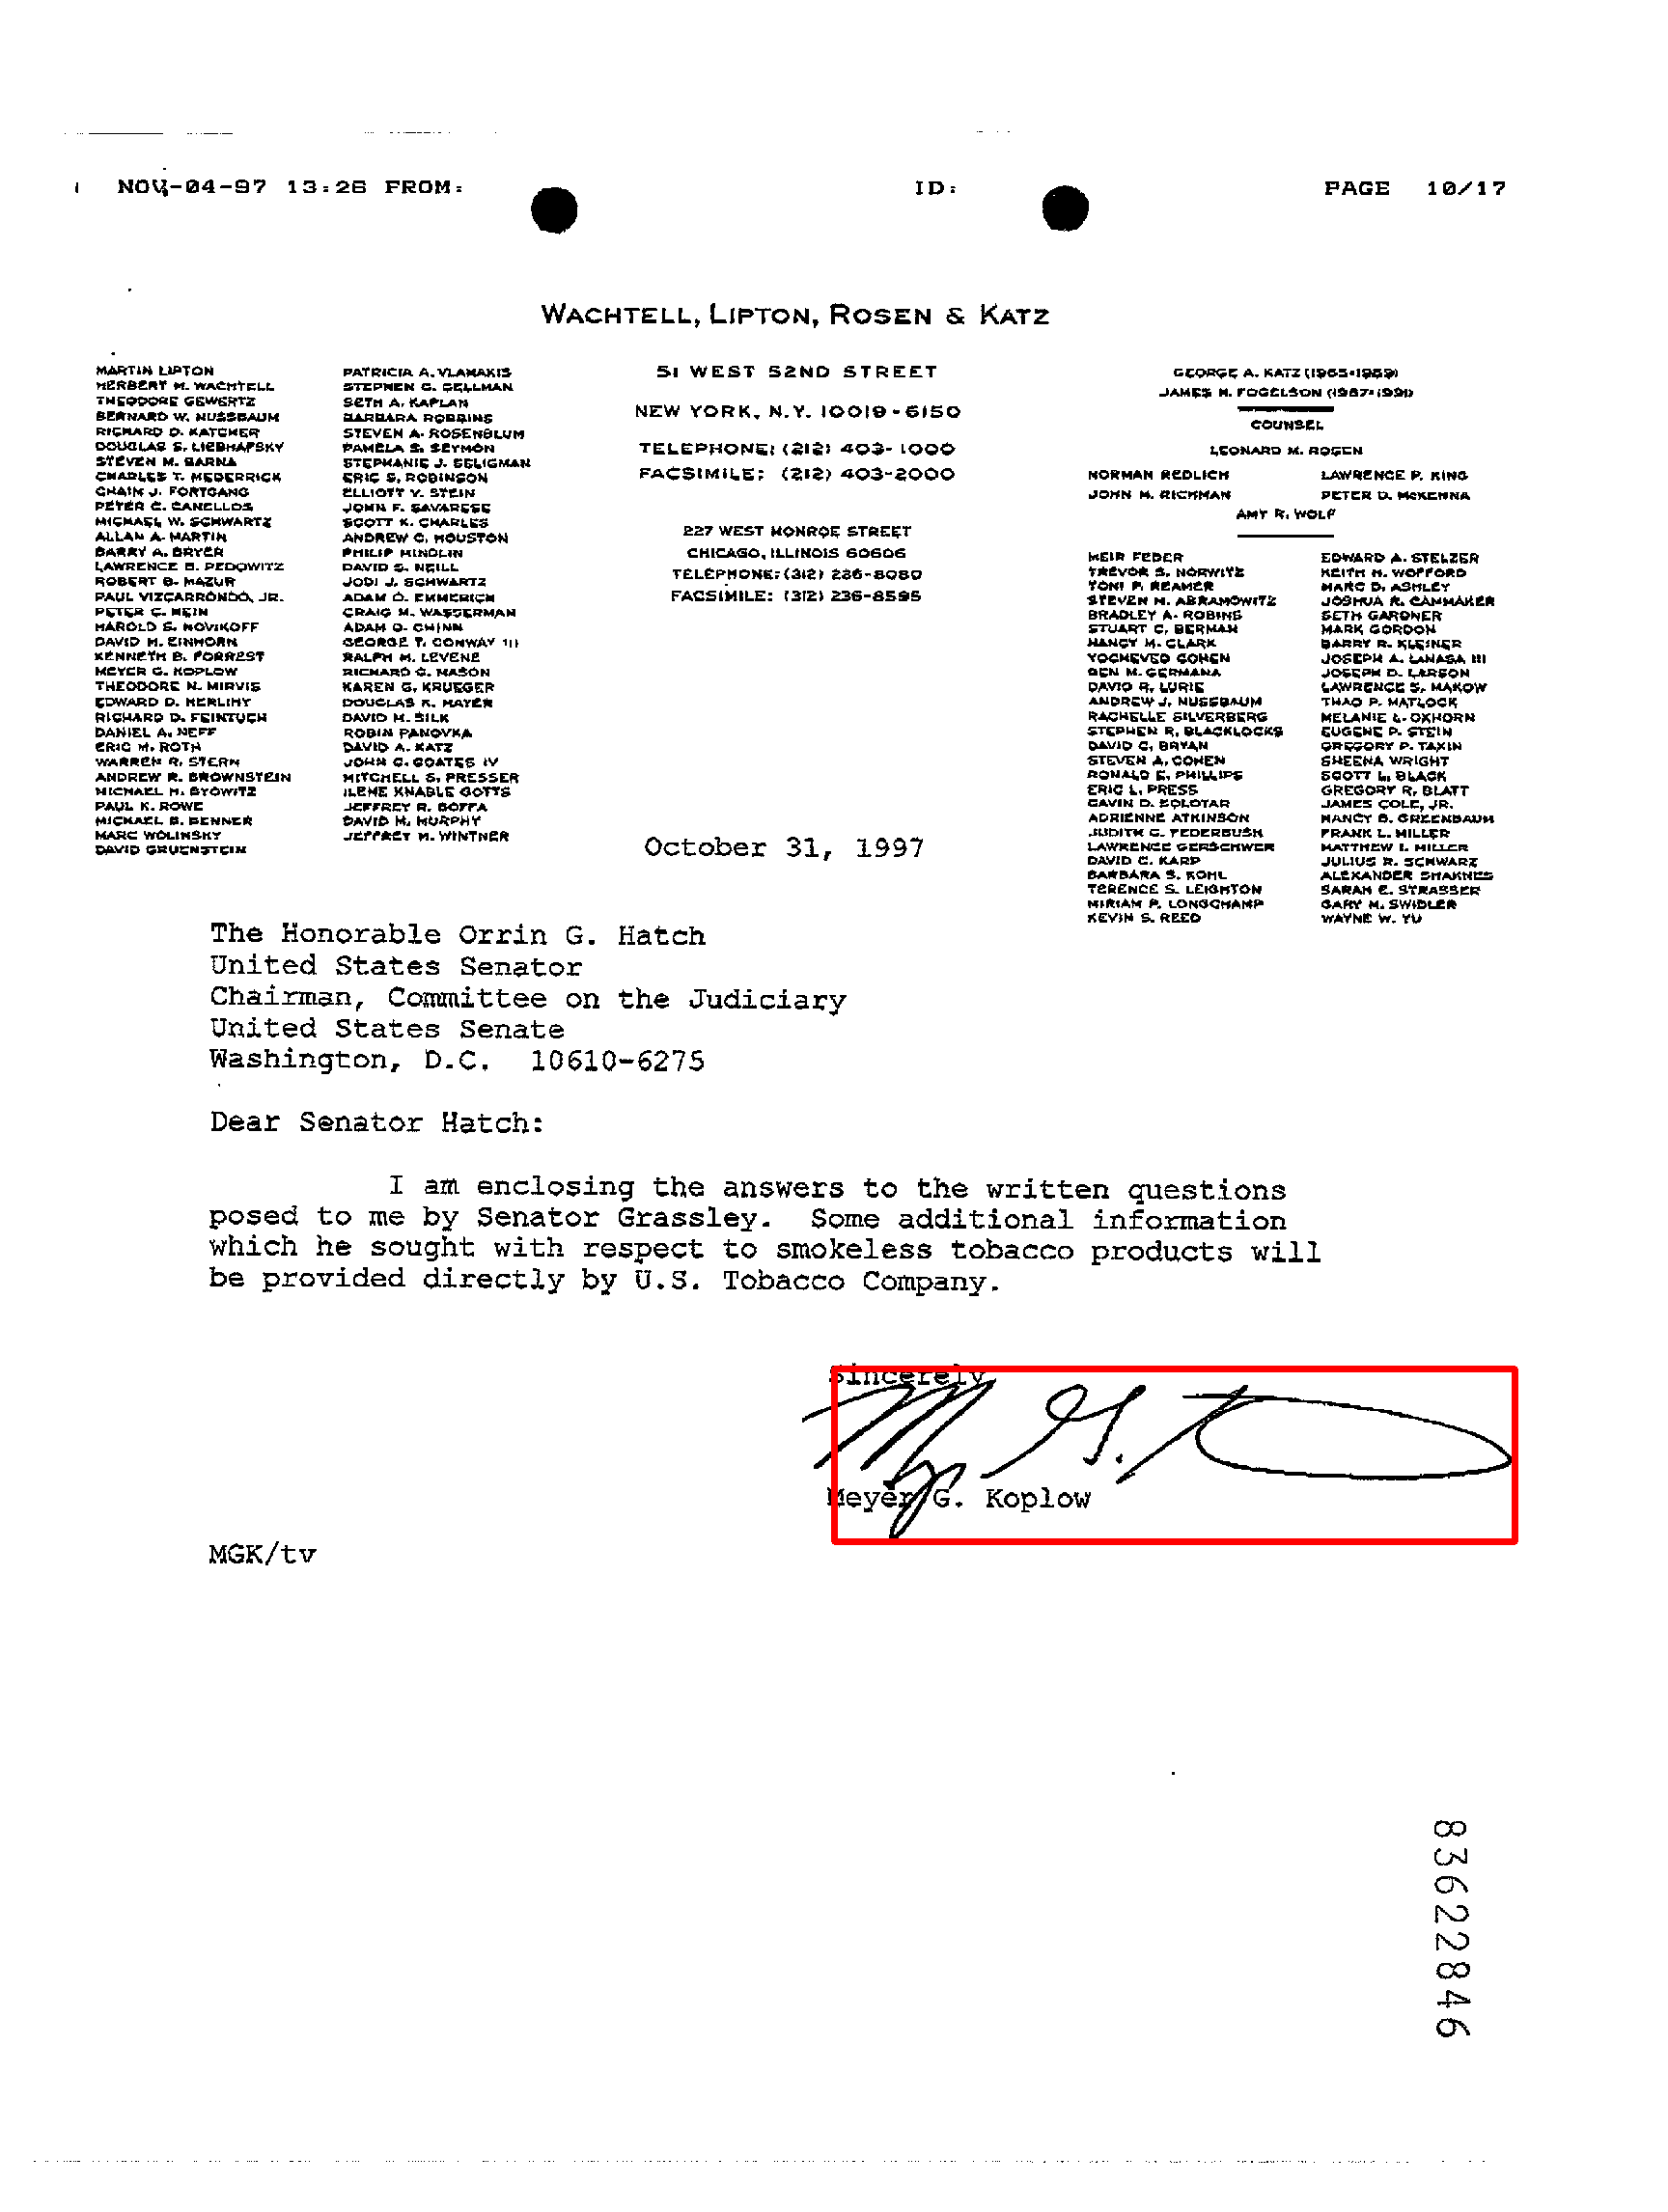

In [32]:
# Drawing bbox using these coordinates on the test image for visualization
original_image = cv2.imread('evaluation/test_image.png')

cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)

PIL.Image.fromarray(original_image)

In [33]:
# Show calculated bbox values for method 6
calculated_6_values_json = pd.read_json('evaluation/calculated_bbox_6.json')
calculated_6_values_json

,gmk15f00.tif,mub51a00.tif,fzh11c00-var.tif,dny38c00_5.tif,was45f00.tif,sfw98c00.tif,lfw39d00.tif,lfv39d00.tif,vbd23f00.tif,mzd01a00.tif,...,yas45f00.tif,cxi59c00_1.tif,wau30a00-page9_16.tif,ihz25e00.tif,arz92e00.tif,gxp01f00_1.tif,azb11c00.tif,aik94f00-page02_2.tif,pvx38c00-page06_6.tif,fbv15e00.tif
0,735,625,1881,991,720,977,1318,1579,1272,188,...,732,378,1456,1305,1280,135,260,597,851,1312
1,1095,1032,613,1453,813,1320,1654,1635,2467,371,...,934,1663,1729,1758,1732,116,2030,1286,634,2058
2,960,1026,2020,1191,855,1216,2098,2350,2327,307,...,837,617,2371,1787,2370,415,976,714,1376,2401
3,1177,1112,764,1544,886,1521,2402,3055,2900,420,...,1001,1803,1997,2780,3009,177,2173,1393,745,2691


In [34]:
# Show iou results for method 6
iou_6_values_json = pd.read_json('evaluation/iou_6.json')
iou_6_values_json

,suh90a00.tif,amk00a00.tif,mwj41f00.tif,umw13f00.tif,fny38c00-page05_5.tif,fzx20e00-page02_2.tif,vdr55d00.tif,dgw64a00.tif,ciy01a00-page02_2.tif,wau30a00-page9_3.tif,...,lfj35f00.tif,fjx9aa00.tif,lec44c00.tif,wav95e00-page03_3.tif,hfv39d00.tif,jxp35f00.tif,eqp14e00-page02_2.tif,qit05f00-page2_36.tif,qit05f00-page2_22.tif,yrz52d00.tif
ground_truth,"[651, 1123, 851, 1195]","[1234, 2436, 2140, 2809]","[651, 784, 964, 860]","[1355, 1952, 2153, 2126]","[158, 1260, 514, 1360]","[1254, 1614, 1692, 1746]","[511, 1437, 1006, 1552]","[1018, 1586, 1358, 1645]","[636, 756, 849, 811]","[679, 1613, 1346, 1794]",...,"[762, 890, 962, 988]","[146, 1641, 1200, 1854]","[794, 1836, 1486, 2011]","[302, 1888, 833, 2024]","[1635, 2855, 2306, 2965]","[727, 1345, 849, 1423]","[1436, 1413, 2060, 1576]","[592, 729, 934, 875]","[673, 1175, 966, 1284]","[894, 1594, 1295, 1718]"
calculated,"[678, 658, 891, 739]","[1359, 2539, 1621, 2630]","[652, 793, 957, 857]","[1357, 1956, 2147, 2118]","[965, 1495, 1183, 1888]","[1347, 1647, 2319, 3233]","[2360, 2961, 2396, 3008]","[864, 1144, 1355, 1650]","[688, 748, 861, 810]","[1423, 2184, 2329, 2649]",...,"[600, 925, 992, 1226]","[1294, 1759, 2112, 2734]","[864, 1833, 1014, 2014]","[1388, 1948, 1419, 2022]","[1507, 1706, 2298, 2958]","[733, 1185, 794, 1417]","[1451, 1427, 2058, 1538]","[600, 787, 689, 874]","[673, 1176, 965, 1281]","[895, 1594, 1254, 1722]"
intersection,"[678, 1123, 851, 739]","[1359, 2539, 1621, 2630]","[652, 793, 957, 857]","[1357, 1956, 2147, 2118]","[965, 1495, 514, 1360]","[1347, 1647, 1692, 1746]","[2360, 2961, 1006, 1552]","[1018, 1586, 1355, 1645]","[688, 756, 849, 810]","[1423, 2184, 1346, 1794]",...,"[762, 925, 962, 988]","[1294, 1759, 1200, 1854]","[864, 1836, 1014, 2011]","[1388, 1948, 833, 2022]","[1635, 2855, 2298, 2958]","[733, 1345, 794, 1417]","[1451, 1427, 2058, 1538]","[600, 787, 689, 874]","[673, 1176, 965, 1281]","[895, 1594, 1254, 1718]"
iou_in_percentage,0,7.06,82.06,92.17,0,2.18,0,8,63.24,0,...,10.08,0,21.52,0,6.86,22.78,66.24,15.51,96,87.01


## Results

I plotted the frequency of iou value for different intervals from 0% to 100%

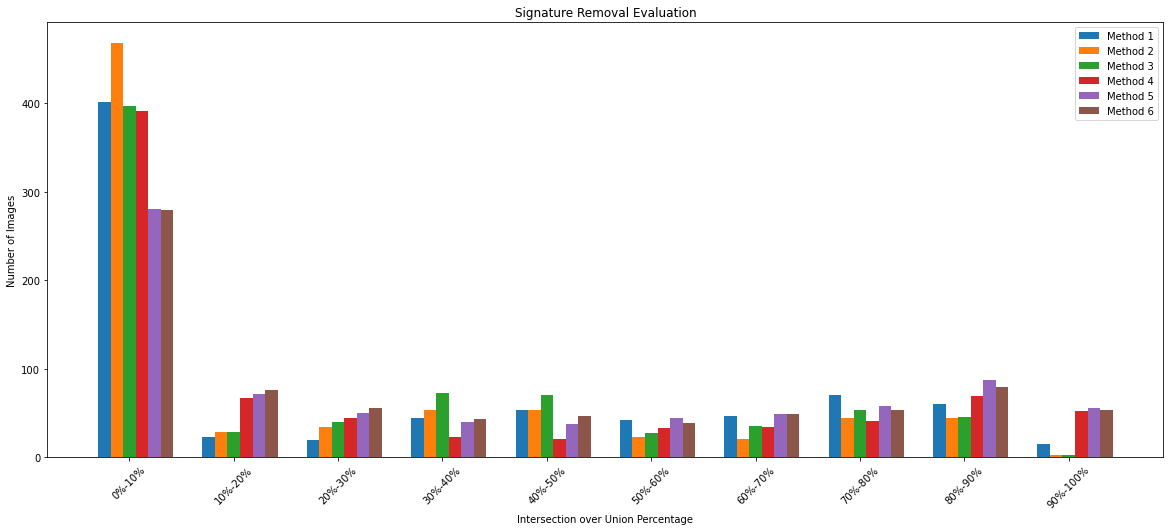

In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np


def visualize_evaluation(evaluation_json):
    f = open(evaluation_json, )
    evaluation_data = json.load(f)
    f.close()

    zero_to_ten, ten_to_twenty, twenty_to_thirty, thirty_to_forty, forty_to_fifthy, fifthy_to_sixty, \
    sixty_to_seventy, seventy_to_eighty, eighty_to_ninety, ninety_to_hundered = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

    for filename in evaluation_data.keys():
        if evaluation_data[filename]['iou_in_percentage'] < 10:
            zero_to_ten = zero_to_ten + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 20:
            ten_to_twenty = ten_to_twenty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 30:
            twenty_to_thirty = twenty_to_thirty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 40:
            thirty_to_forty = thirty_to_forty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 50:
            forty_to_fifthy = forty_to_fifthy + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 60:
            fifthy_to_sixty = fifthy_to_sixty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 70:
            sixty_to_seventy = sixty_to_seventy + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 80:
            seventy_to_eighty = seventy_to_eighty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 90:
            eighty_to_ninety = eighty_to_ninety + 1
        elif evaluation_data[filename]['iou_in_percentage'] <= 100:
            ninety_to_hundered = ninety_to_hundered + 1

    # Plot
    x_axis_labels = [
        '0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%',
        '70%-80%', '80%-90%', '90%-100%'
    ]
    frequency = [
        zero_to_ten, ten_to_twenty, twenty_to_thirty, thirty_to_forty,
        forty_to_fifthy, fifthy_to_sixty, sixty_to_seventy, seventy_to_eighty,
        eighty_to_ninety, ninety_to_hundered
    ]

    return x_axis_labels, frequency


# Method 1
iou_1_json = 'evaluation/iou_1.json'
x_axis_labels, frequency_method_1 = visualize_evaluation(iou_1_json)
# Method 2
iou_2_json = 'evaluation/iou_2.json'
x_axis_labels, frequency_method_2 = visualize_evaluation(iou_2_json)
# Method 3
iou_3_json = 'evaluation/iou_3.json'
x_axis_labels, frequency_method_3 = visualize_evaluation(iou_3_json)
# Method 4
iou_4_json = 'evaluation/iou_4.json'
x_axis_labels, frequency_method_4 = visualize_evaluation(iou_4_json)
# Method 5
iou_5_json = 'evaluation/iou_5.json'
x_axis_labels, frequency_method_5 = visualize_evaluation(iou_5_json)
# Method 6
iou_6_json = 'evaluation/iou_6.json'
x_axis_labels, frequency_method_6 = visualize_evaluation(iou_6_json)

fig = plt.figure(figsize=(20, 8))
w = 0.12
X_axis_1 = np.arange(len(x_axis_labels))
X_axis_2 = [i+w for i in X_axis_1]
X_axis_3 = [i+w for i in X_axis_2]
X_axis_4 = [i+w for i in X_axis_3]
X_axis_5 = [i+w for i in X_axis_4]
X_axis_6 = [i+w for i in X_axis_5]

plt.bar(X_axis_1, frequency_method_1, w, label='Method 1')
plt.bar(X_axis_2, frequency_method_2, w, label='Method 2')
plt.bar(X_axis_3, frequency_method_3, w, label='Method 3')
plt.bar(X_axis_4, frequency_method_4, w, label='Method 4')
plt.bar(X_axis_5, frequency_method_5, w, label='Method 5')
plt.bar(X_axis_6, frequency_method_6, w, label='Method 6')


plt.xticks(X_axis_3, x_axis_labels) # keep in center
plt.xticks(rotation=45)
plt.xlabel("Intersection over Union Percentage")
plt.ylabel("Number of Images")
plt.title("Signature Removal Evaluation")
plt.legend()
plt.show()